In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm, trange
import seaborn as sns
from PIL import Image
from scipy.stats import gaussian_kde
# from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from cellpose.io import imread
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from kneed import KneeLocator

# Проверка наличия видеокарты

In [1]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

"nvcc" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"nvidia-smi" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


>>> GPU activated? NO


In [2]:
from cellpose import io, models
io.logger_setup()

2025-05-23 20:13:26,097 [INFO] WRITING LOG OUTPUT TO C:\Users\gorod\.cellpose\run.log
2025-05-23 20:13:26,120 [INFO] 
cellpose version: 	3.0.10 
platform:       	win32 
python version: 	3.8.19 
torch version:  	2.3.1+cpu


(<Logger cellpose.io (INFO)>, WindowsPath('C:/Users/gorod/.cellpose/run.log'))

# Функции для анализа и отображения распределений

In [3]:
def get_patient_file_paths(path, ftype='.tif'):
    return [os.path.join(path, file) for file in os.listdir(path) if ftype in file]


# def filter_data(data, percent=0.01): эта функция иногда дает ошибку (разное количество в выборках), ниже дипсик исправил
#     # Определяем границы квантилей
#     lower_quantile = percent/2  # Нижний квантиль
#     upper_quantile = 1 - percent/2  # Верхний квантиль

#     # Рассчитаем значения квантилей
#     lower_threshold = np.quantile(data, lower_quantile)  # Квантиль percent/2
#     upper_threshold = np.quantile(data, upper_quantile)  # Квантиль 1-percent/2

#     # Отфильтруем точки, принадлежащие квантилю percent/2 – 1-percent/2
#     filtered_data = data[(data >= lower_threshold) & (data <= upper_threshold)]
#     return filtered_data


def filter_data(data, percent=0.01):
    if len(data) == 0:
        return data.copy()
    
    # Сортируем данные для точного расчета
    sorted_data = np.sort(data)
    n = len(sorted_data)
    
    # Рассчитываем индексы границ
    lower_index = int(np.floor(percent/2 * n))
    upper_index = int(np.ceil((1 - percent/2) * n)) - 1
    
    # Корректируем индексы, чтобы они не выходили за границы массива
    lower_index = max(0, lower_index)
    upper_index = min(n - 1, upper_index)
    
    # Отбираем данные по индексам
    filtered_data = sorted_data[lower_index:upper_index + 1]
    return filtered_data


def analyse_patient(files, model, scale=1/14.4, percent=0.01):
    widths = []
    lengths = []
    areas = []
    EI = []
    DI = []

    for file in files:
        # обработка изображений
        img = imread(file)
        masks, flows, styles = model.eval(img, diameter=105, channels=[0,0])
        masks = masks[10:-10, 10:-10]
        masks = utils.remove_edge_masks(masks, change_index=True)

        # нахождение контуров
        for i in range(1, masks.max()+1):
            mask = masks.copy()
            mask[mask != i] = 0
            mask[mask == i] = 1
            mask = np.array(mask, np.uint8)
            contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
            cnt = contour[0]
            try:
                ellipse = cv2.fitEllipse(cnt) # проверка, достаточно ли точек
            except Exception:
                # cell_count -= 1
                continue
            L = max(ellipse[1]) * scale
            W = min(ellipse[1]) * scale
            if W <= 0:
                continue
            areas.append(cv2.contourArea(cnt) * scale**2)
            lengths.append(L)
            widths.append(W)
            EI.append(L/W)
            DI.append((L-W)/(L+W))
    # фильтруем клетки, которые редко попадаются
    if percent > 0:
        lengths = filter_data(np.array(lengths), percent=percent)
        areas = filter_data(np.array(areas), percent=percent)
        EI = filter_data(np.array(EI), percent=percent)
        DI = filter_data(np.array(DI), percent=percent)
    else:
        lengths = np.array(lengths)
        areas = np.array(areas)
        EI = np.array(EI)
        DI = np.array(DI)
    DI_mean = np.mean(DI)
    DI_std = np.std(DI)
    DI_w = fwhm(*kde_plot(DI))
    DI_BC = bimodality_coefficient(DI)
    DI_KC = calc_silhouette_score(DI)
    cell_count = len(lengths)
    return cell_count, lengths, areas, EI, DI, DI_mean, DI_std, DI_w, DI_BC, DI_KC


def draw_data(data, bw_scale=1, points=10000, color=None):
    # calculate the optimal bandwidth using Silverman's rule
    std_dev = np.std(data)
    bandwidth = 1.06 * std_dev * len(data) ** (-1/5) * bw_scale

    plot_x = np.linspace(np.min(data), np.max(data), points)
    kde = gaussian_kde(data, bw_method=bandwidth/std_dev)
    pdf = kde.pdf(plot_x)
    if not color==None:
        plt.plot(plot_x, pdf, color=color)
    else:
        plt.plot(plot_x, pdf)


def kde_plot(data, bw_scale=1, points=10000):
    std_dev = np.std(data)
    bandwidth = 1.06 * std_dev * len(data) ** (-1/5) * bw_scale

    plot_x = np.linspace(np.min(data), np.max(data), points)
    kde = gaussian_kde(data, bw_method=bandwidth/std_dev)
    pdf = kde.pdf(plot_x)
    return plot_x, pdf


def fwhm(x, y):
    max_y = np.max(y)  # Значение максимума
    half_max = max_y / 2  # Половина от максимума

    # Находим индексы, где функция пересекает половину максимума
    indices = np.where(y >= half_max)[0]  # Все индексы, где y >= half_max
    x_left = x[indices[0]]  # Первая точка пересечения (левая граница)
    x_right = x[indices[-1]]  # Последняя точка пересечения (правая граница)

    # Вычисляем FWHM
    fwhm = abs(x_right - x_left)
    return fwhm


def bimodality_coefficient(data):
    """
    Рассчитывает коэффициент унимодальности/бимодальности (Bimodality Coefficient, BC).

    Для унимодальных распределений BC < 0.55, для бимодальных — BC >= 0.55.

    Параметры:
        data (array-like): Набор значений случайной величины.

    Возвращает:
        float: Коэффициент бимодальности.
    """
    # Размер выборки
    n = len(data)

    # Коэффициенты асимметрии и эксцесса
    gamma = skew(data)  # Асимметрия
    kappa = kurtosis(data, fisher=True)  # Эксцесс (Fisher: относительно нормального распределения)

    # Коэффициент бимодальности
    bc = (gamma**2 + 1) / (kappa + 3 * ((n - 1)**2) / ((n - 2) * (n - 3)))

    return bc


def calc_silhouette_score(data):
    kmeans = KMeans(n_clusters=2, random_state=42)
    return silhouette_score(data.reshape(-1,1), kmeans.fit_predict(data.reshape(-1,1)))


def analyse_files(data, model, percent=0.01, save_intermediate_calculations=True, calculations_name=None, make_summary=True, summary_name=None):
    database = {}
    data_traces = {}

    for measurement, path in tqdm(data.items()):
        file_paths = get_patient_file_paths(path, ftype='.png')
        cell_count, lengths, areas, EI, DI, DI_mean, DI_std, DI_w, DI_BC, DI_KC = analyse_patient(file_paths, model, percent=percent)
        database[measurement] = {}
        database[measurement]["cell_count"] = int(cell_count)
        database[measurement]["length_mean"] = np.mean(lengths)
        database[measurement]["area_mean"] = np.mean(areas)
        database[measurement]["EI_mean"] = np.mean(EI)
        database[measurement]["DI_mean"] = DI_mean
        database[measurement]["DI_std"] = DI_std
        database[measurement]["DI_w"] = DI_w
        database[measurement]["DI_BC"] = DI_BC
        database[measurement]["DI_KC"] = DI_KC
    
        data_traces[measurement] = {}
        data_traces[measurement]["lengths"] = lengths
        data_traces[measurement]["areas"] = areas
        data_traces[measurement]["EI"] = EI
        data_traces[measurement]["DI"] = DI

    database_pd = pd.DataFrame.from_dict(database)
    print(database_pd)

    if save_intermediate_calculations:
        if calculations_name == None:
            print('Введете название (calculations_name)')
        
        dataframes = []

        for measurement_name, measurement_data in data_traces.items():
            df = pd.DataFrame(measurement_data)
            df.insert(0, "measurement", measurement_name)
            dataframes.append(df)

        result_df = pd.concat(dataframes, ignore_index=True)

        result_df.to_excel(f'{calculations_name}.xlsx', index=False)
            
    
    if make_summary:
        if summary_name == None:
            print('Введете название (summary_name)')
        database_pd.to_excel(f'{summary_name}.xlsx', index=True)
    
    return database, data_traces


def draw_graphs(data_traces, legend=None):
    titles = {"lengths" : "длина (мкм)", "areas" : "площадь (ммк^2)", "EI" : "EI", "DI" : "DI"}

    for trace_type in ["lengths", "areas", "EI", "DI"]:
        for measurement in data_traces.keys():
            draw_data(data_traces[measurement][trace_type])
        plt.title(f'График распределения параметра: {titles[trace_type]}')
        plt.xlabel(titles[trace_type])
        plt.ylabel('Плотность вероятности')
        if legend == None:
            plt.legend([f"№{i+1} (ср. {np.mean(data_traces[list(data_traces.keys())[i]][trace_type]):.2f})" for i in range(len(data_traces.keys()))])
        else:
            plt.legend([f"{legend[i]} (ср. {np.mean(data_traces[list(data_traces.keys())[i]][trace_type]):.2f})" for i in range(len(data_traces.keys()))])
        plt.show()


def load_traces(file):
    df = pd.read_excel(file)
    data_traces = {}

    for measurement_name, group in df.groupby("measurement"):
        measurement_data = group.drop(columns="measurement").to_dict(orient="list")
        for key, value in measurement_data.items():
            measurement_data[key] = np.array(value)
        data_traces[measurement_name] = measurement_data

    return data_traces

In [5]:
model_path = r'E:\Flow chamber analysis\2025-02-13 Cellpose train\Models\models\deform_2025_02_ep5000_lr0_1_SGD'
model = models.CellposeModel(gpu=True, pretrained_model=model_path, nchan=2)

2025-03-24 14:37:41,553 [INFO] ** TORCH CUDA version installed and working. **
2025-03-24 14:37:41,554 [INFO] >>>> using GPU (CUDA)
2025-03-24 14:37:41,629 [INFO] >>>> loading model E:\Flow chamber analysis\2025-02-13 Cellpose train\Models\models\deform_2025_02_ep5000_lr0_1_SGD
2025-03-24 14:37:42,229 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-03-24 14:37:42,230 [INFO] >>>> model diam_labels =  102.889 (mean diameter of training ROIs)


# Зависимость нормы от номера измерения

## С самого начала измерения

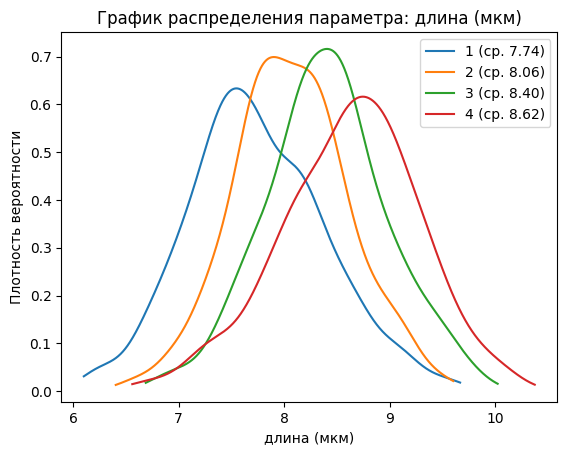

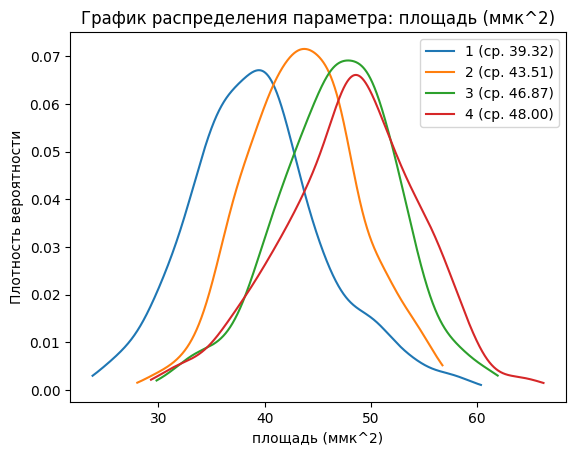

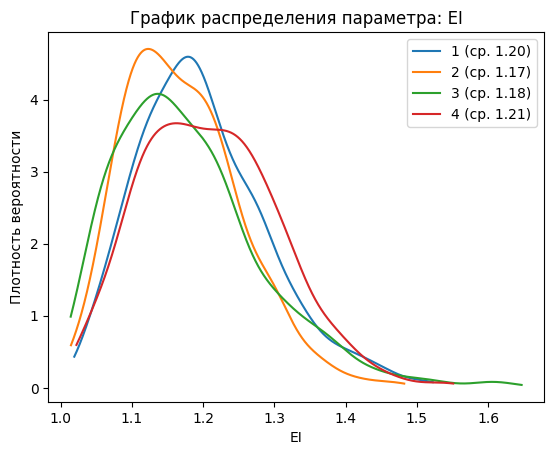

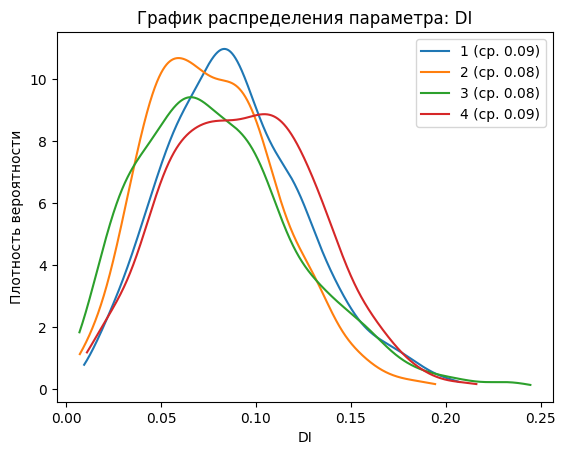

In [7]:
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\4"
}

database, data_traces = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-03-19 all (norm)',
    summary_name='2025-03-19 summary (norm)'
)

draw_graphs(
    data_traces,
    legend=list(data.keys())
)

database_pd = pd.DataFrame.from_dict(database)
database_pd

In [15]:
database_pd

1           2            3           4
cell_count   1263.000000  732.000000  1077.000000  886.000000
length_mean     7.742687    8.063351     8.397011    8.616974
area_mean      39.317831   43.506966    46.866392   48.000696
EI_mean         1.199282    1.170712     1.180368    1.209856
DI_mean         0.089069    0.077369     0.080683    0.093290
DI_std          0.037100    0.033964     0.042437    0.038723
DI_w            0.087513    0.087984     0.098625    0.106951
DI_BC           0.401576    0.405627     0.441367    0.392016
DI_KC           0.562811    0.584906     0.569972    0.583256

2025-03-24 14:46:20,566 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:46:20,568 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:46:20,569 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:46:20,573 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:46:20,574 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

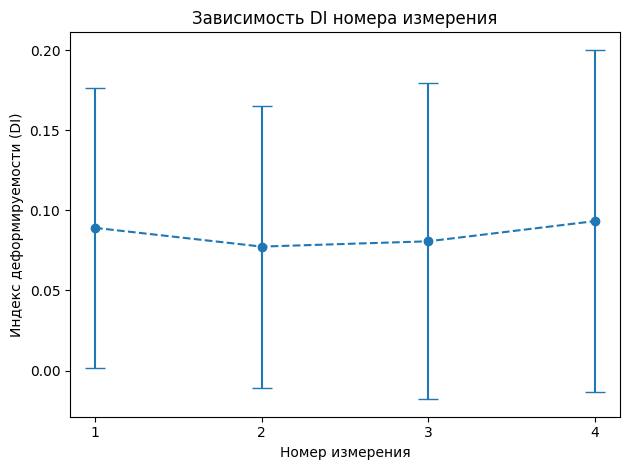

In [13]:
labels = data.keys()

plt.errorbar(labels, database_pd.loc["DI_mean"], yerr = database_pd.loc["DI_w"], fmt='o--', capsize=7)
plt.title("Зависимость DI номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Индекс деформируемости (DI)")
plt.tight_layout()
plt.show()

2025-03-24 14:56:49,880 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:56:49,882 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:56:49,882 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:56:49,884 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 14:56:49,885 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

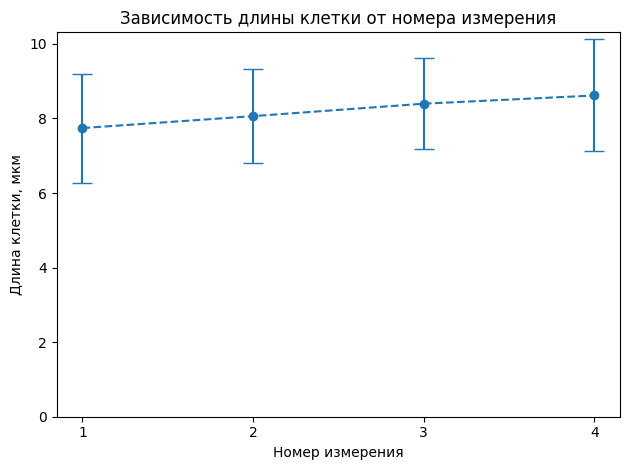

In [26]:
labels = data.keys()

plt.errorbar(labels, database_pd.loc["length_mean"], yerr = [fwhm(*kde_plot(data_traces[m]['lengths'])) for m in labels], fmt='o--', capsize=7)
plt.ylim(bottom=0)
plt.title("Зависимость длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Длина клетки, мкм")
plt.tight_layout()
plt.show()

## Не с начала измерения

Тут другая кровь (АВП). И вообще измерение старое

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:48<00:00, 28.87s/it]


                      1           2           3           4           5  \
cell_count   857.000000  910.000000  549.000000  258.000000  227.000000   
length_mean    8.243576    8.548412    8.416860    8.576069    8.323735   
area_mean     42.119425   44.558834   43.534150   44.761339   42.790178   
EI_mean        1.268979    1.286450    1.275506    1.299492    1.275118   
DI_mean        0.115707    0.122529    0.118256    0.124730    0.116391   
DI_std         0.048770    0.048199    0.048497    0.061854    0.060585   
DI_w           0.109243    0.105923    0.101246    0.093986    0.118986   
DI_BC          0.316328    0.263635    0.300819    0.358615    0.281723   
DI_KC          0.541839    0.527179    0.514136    0.719600    0.515039   

                      6           7           8           9          10  
cell_count   305.000000  238.000000  236.000000  231.000000  536.000000  
length_mean    8.485709    8.496418    8.634372    8.769436    8.483913  
area_mean     43.718907   4

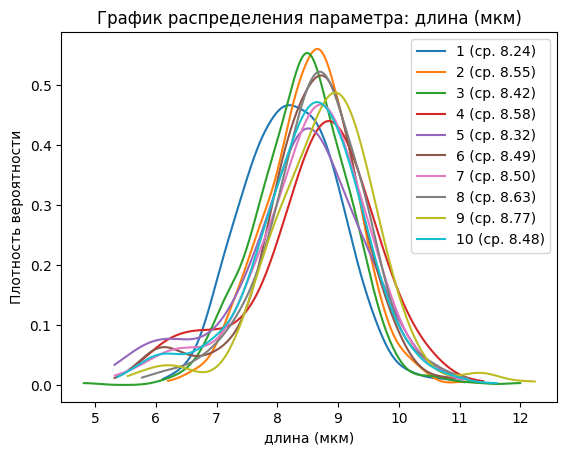

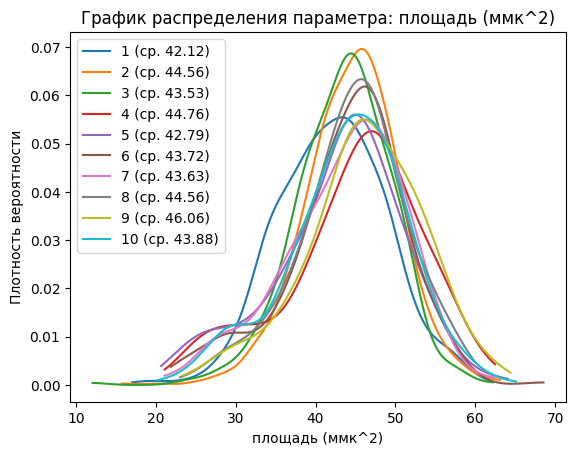

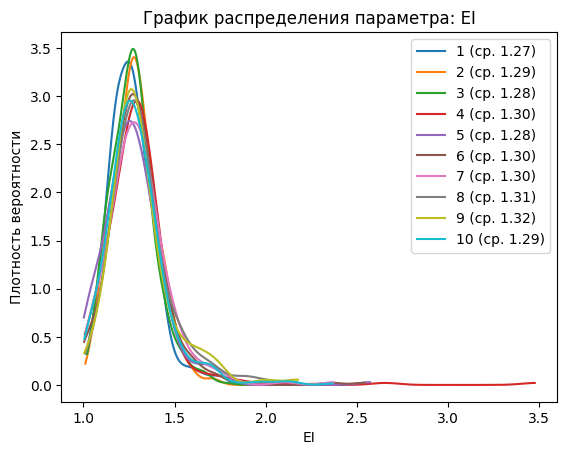

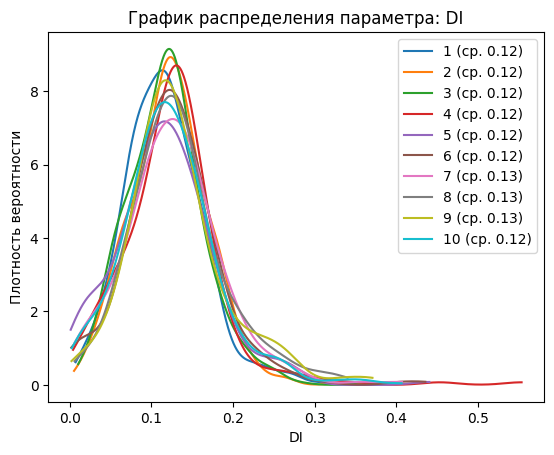

1           2           3           4           5  \
cell_count   857.000000  910.000000  549.000000  258.000000  227.000000   
length_mean    8.243576    8.548412    8.416860    8.576069    8.323735   
area_mean     42.119425   44.558834   43.534150   44.761339   42.790178   
EI_mean        1.268979    1.286450    1.275506    1.299492    1.275118   
DI_mean        0.115707    0.122529    0.118256    0.124730    0.116391   
DI_std         0.048770    0.048199    0.048497    0.061854    0.060585   
DI_w           0.109243    0.105923    0.101246    0.093986    0.118986   
DI_BC          0.316328    0.263635    0.300819    0.358615    0.281723   
DI_KC          0.541839    0.527179    0.514136    0.719600    0.515039   

                      6           7           8           9          10  
cell_count   305.000000  238.000000  236.000000  231.000000  536.000000  
length_mean    8.485709    8.496418    8.634372    8.769436    8.483913  
area_mean     43.718907   43.627876   44.561667   46.060838   43.880352  
EI_mean        1.296139    1.302037    1.314459    1.315462    1.291192  
DI_mean        0.124840    0.126765    0.131712    0.131524    0.122774  
DI_std         0.057370    0.059997    0.058118    0.061094    0.059145  
DI_w           0.107741    0.118060    0.106541    0.095782    0.111680  
DI_BC          0.264201    0.298839    0.376151    0.403139    0.331651  
DI_KC          0.515415    0.515017    0.582810    0.633982    0.528599

In [46]:
data = {
    "1" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\1",
    "2" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\2",
    "3" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\3",
    "4" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\4",
    "5" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\5",
    "6" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\6",
    "7" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\7",
    "8" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\8",
    "9" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\9",
    "10" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\10"
}

database, data_traces = analyse_files(
    data,
    model,
    percent=0.001,
    calculations_name='2025-03-19 all (avp, norm)',
    summary_name='2025-03-19 summary (avp, norm)'
)

draw_graphs(
    data_traces,
    legend=list(data.keys())
)

database_pd = pd.DataFrame.from_dict(database)
database_pd

2025-03-24 16:13:15,800 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:15,804 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:15,806 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:15,810 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:15,812 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

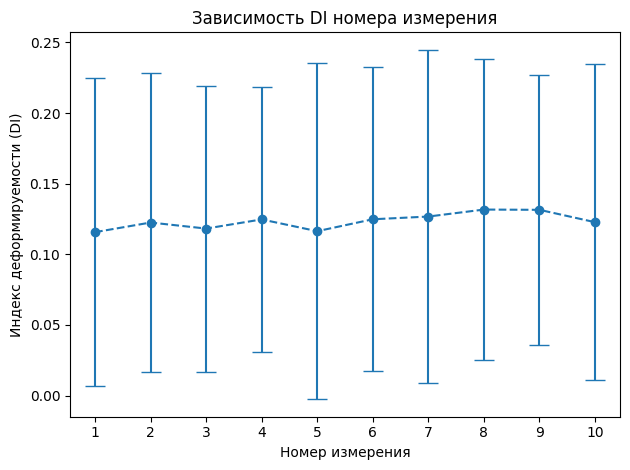

In [47]:
labels = data.keys()

plt.errorbar(labels, database_pd.loc["DI_mean"], yerr = database_pd.loc["DI_w"], fmt='o--', capsize=7)
plt.title("Зависимость DI номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Индекс деформируемости (DI)")
plt.tight_layout()
plt.show()

2025-03-24 16:13:17,218 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:17,220 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:17,221 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:17,223 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 16:13:17,224 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

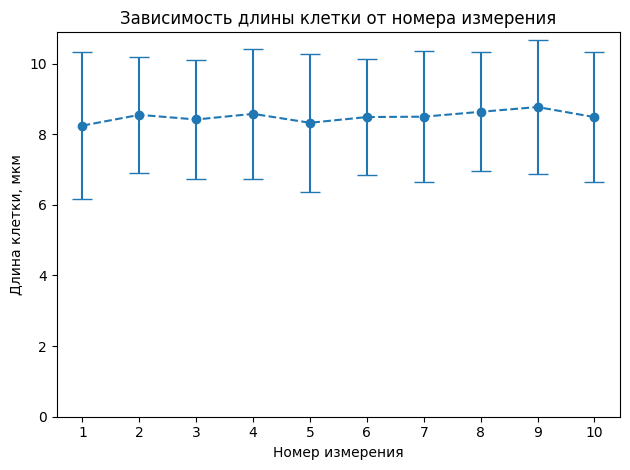

In [48]:
labels = data.keys()

plt.errorbar(labels, database_pd.loc["length_mean"], yerr = [fwhm(*kde_plot(data_traces[m]['lengths'])) for m in labels], fmt='o--', capsize=7)
plt.ylim(bottom=0)
plt.title("Зависимость длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Длина клетки, мкм")
plt.tight_layout()
plt.show()

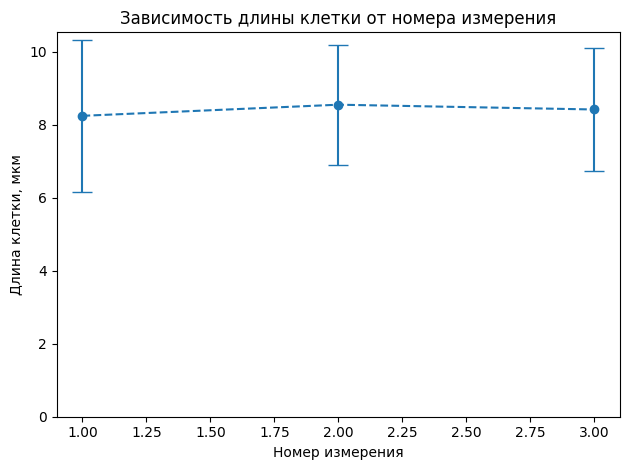

In [15]:
data = {
    "1" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\1",
    "2" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\2",
    "3" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\3",
    "4" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\4",
    "5" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\5",
    "6" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\6",
    "7" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\7",
    "8" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\8",
    "9" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\9",
    "10" : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\10"
}

data = {
    1 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\1",
    2 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\2",
    3 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\3",
    4 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\4",
    5 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\5",
    6 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\6",
    7 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\7",
    8 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\8",
    9 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\9",
    10 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\10"
}

data_traces = load_traces(r'E:\Flow chamber analysis\2025-03-19 Glytar analysis 4\2025-03-19 all (avp, norm).xlsx')
database_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-03-19 Glytar analysis 4\2025-03-19 summary (avp, norm).xlsx', index_col=0)

labels = [1,2,3]



plt.errorbar(labels, database_pd.loc["length_mean"][:3], yerr = [fwhm(*kde_plot(data_traces[m]['lengths'])) for m in labels], fmt='o--', capsize=7)
plt.ylim(bottom=0)
plt.title("Зависимость длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Длина клетки, мкм")
plt.tight_layout()
plt.show()

In [10]:
database_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-03-19 Glytar analysis 4\2025-03-19 summary (avp, norm).xlsx', index_col=0)
control = database_pd.loc["length_mean"][5:8]
control

6    8.485709
7    8.496418
8    8.634372
Name: length_mean, dtype: float64

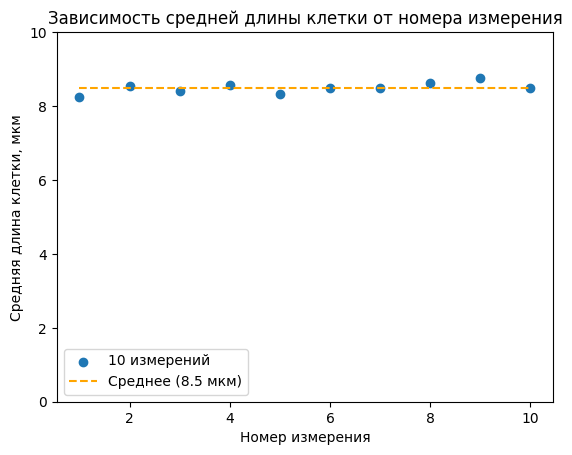

In [25]:
data = {
    1 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\1",
    2 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\2",
    3 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\3",
    4 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\4",
    5 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\5",
    6 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\6",
    7 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\7",
    8 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\8",
    9 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\9",
    10 : r"E:\Flow chamber\Ladynin\2024-11-26-flow chamber\Deform\10"
}

data_traces = load_traces(r'E:\Flow chamber analysis\2025-03-19 Glytar analysis 4\2025-03-19 all (avp, norm).xlsx')
database_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-03-19 Glytar analysis 4\2025-03-19 summary (avp, norm).xlsx', index_col=0)

labels = data.keys()

plt.scatter(labels, database_pd.loc["length_mean"])
plt.plot(labels, [database_pd.loc["length_mean"].mean()] * 10, 'orange', linestyle='--')
plt.ylim(bottom=0, top=10)
plt.title("Зависимость средней длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Средняя длина клетки, мкм")
plt.legend(['10 измерений', 'Среднее (8.5 мкм)'])
# plt.tight_layout()
plt.show()

# Зависимость от концентрациии и соотношения

In [32]:
data = {
    "0.01% (10:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.01 (10-1)",
    "0.01% (50:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.01 (50-1)",
    "0.01% (100:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.01 (100-1)",
    "0.1% (10:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.1 (10-1)",
    "0.1% (50:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.1 (50-1)",
    "0.1% (100:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.1 (100-1)"
}

database, data_traces = analyse_files(
    data,
    model,
    percent=0.001,
    calculations_name='2025-03-19 all (fixed)',
    summary_name='2025-03-19 summary (fixed)'
)

draw_graphs(
    data_traces,
    legend=list(data.keys())
)

database_pd = pd.DataFrame.from_dict(database)
database_pd

NameError: name 'model' is not defined

In [12]:
data = {
    "0.01% (10:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.01 (10-1)",
    "0.01% (50:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.01 (50-1)",
    "0.01% (100:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.01 (100-1)",
    "0.1% (10:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.1 (10-1)",
    "0.1% (50:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.1 (50-1)",
    "0.1% (100:1)" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\0.1 (100-1)"
}

database_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-03-19 Glytar analysis 4\2025-03-19 summary (fixed).xlsx', index_col=0)

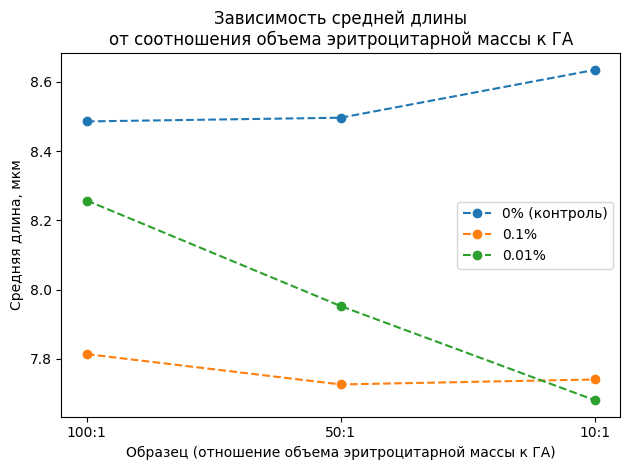

In [19]:
labels = ['10:1', '50:1', '100:1'][::-1]

plt.plot(labels, control, 'o--')

keys = list(data.keys())[:3][::-1]
plt.plot(labels, database_pd[keys].loc["length_mean"], 'o--')
# plt.errorbar(labels, database_pd[keys].loc["DI_mean"], yerr = database_pd[keys].loc["DI_w"], fmt='o--', capsize=7)

keys = list(data.keys())[3:][::-1]
# plt.errorbar(labels, database_pd[keys].loc["DI_mean"], yerr = database_pd[keys].loc["DI_w"], fmt='o--', capsize=7)
plt.plot(labels, database_pd[keys].loc["length_mean"], 'o--')

plt.legend(['0% (контроль)', '0.1%', '0.01%'])

plt.title("Зависимость средней длины\nот отношения объема эритроцитарной массы к ГА")
plt.xlabel("Образец (отношение объема эритроцитарной массы к ГА)")
plt.ylabel("Средняя длина, мкм")
plt.tight_layout()
plt.show()

In [44]:
number = 245245
base = 20

# Используем format с указанием основания
result = format(number, f'0{base}')  # или просто format(number, 'x') для 20-ричной, но так не получится
result

'00000000000000245245'

In [48]:
print(format(255, '020'))

00000000000000000255


In [31]:
labels = ['10:1', '50:1', '100:1'][::-1]

keys = list(data.keys())[:3][::-1]
plt.plot(labels, database_pd[keys].loc["length_mean"], 'o--')
# plt.errorbar(labels, database_pd[keys].loc["DI_mean"], yerr = database_pd[keys].loc["DI_w"], fmt='o--', capsize=7)

keys = list(data.keys())[3:][::-1]
plt.plot(labels, control)
# plt.errorbar(labels, database_pd[keys].loc["DI_mean"], yerr = database_pd[keys].loc["DI_w"], fmt='o--', capsize=7)
plt.plot(labels, database_pd[keys].loc["length_mean"], 'o--')


plt.legend(['0.01%', '0.1%'])

plt.title("Зависимость длины от соотношения эр. масса/ГА")
plt.xlabel("Образец")
plt.ylabel("Длина клетки, мкм")
plt.tight_layout()
plt.show()

KeyError: "None of [Index([3, 2, 1], dtype='int32')] are in the [columns]"

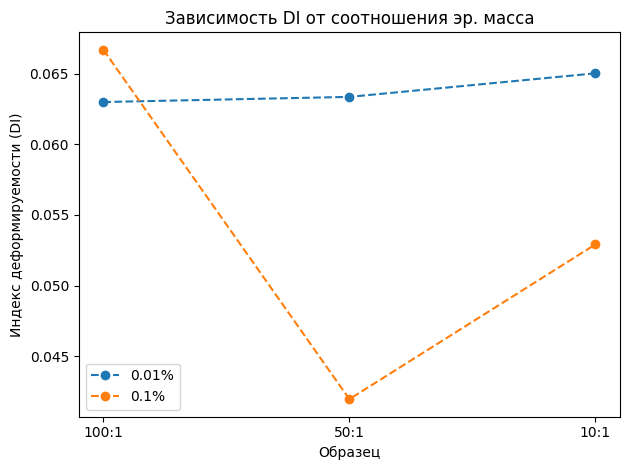

In [51]:
labels = ['10:1', '50:1', '100:1'][::-1]

keys = list(data.keys())[:3][::-1]
plt.plot(labels, database_pd[keys].loc["DI_mean"], 'o--')
# plt.errorbar(labels, database_pd[keys].loc["DI_mean"], yerr = database_pd[keys].loc["DI_w"], fmt='o--', capsize=7)

keys = list(data.keys())[3:][::-1]
# plt.errorbar(labels, database_pd[keys].loc["DI_mean"], yerr = database_pd[keys].loc["DI_w"], fmt='o--', capsize=7)
plt.plot(labels, database_pd[keys].loc["DI_mean"], 'o--')

plt.legend(['0.01%', '0.1%'])

plt.title("Зависимость DI от соотношения эр. масса")
plt.xlabel("Образец")
plt.ylabel("Индекс деформируемости (DI)")
plt.tight_layout()
plt.show()

In [34]:
data_traces = load_traces(r'E:\Flow chamber analysis\2025-03-19 Glytar analysis 4\2025-03-19 all (fixed).xlsx')

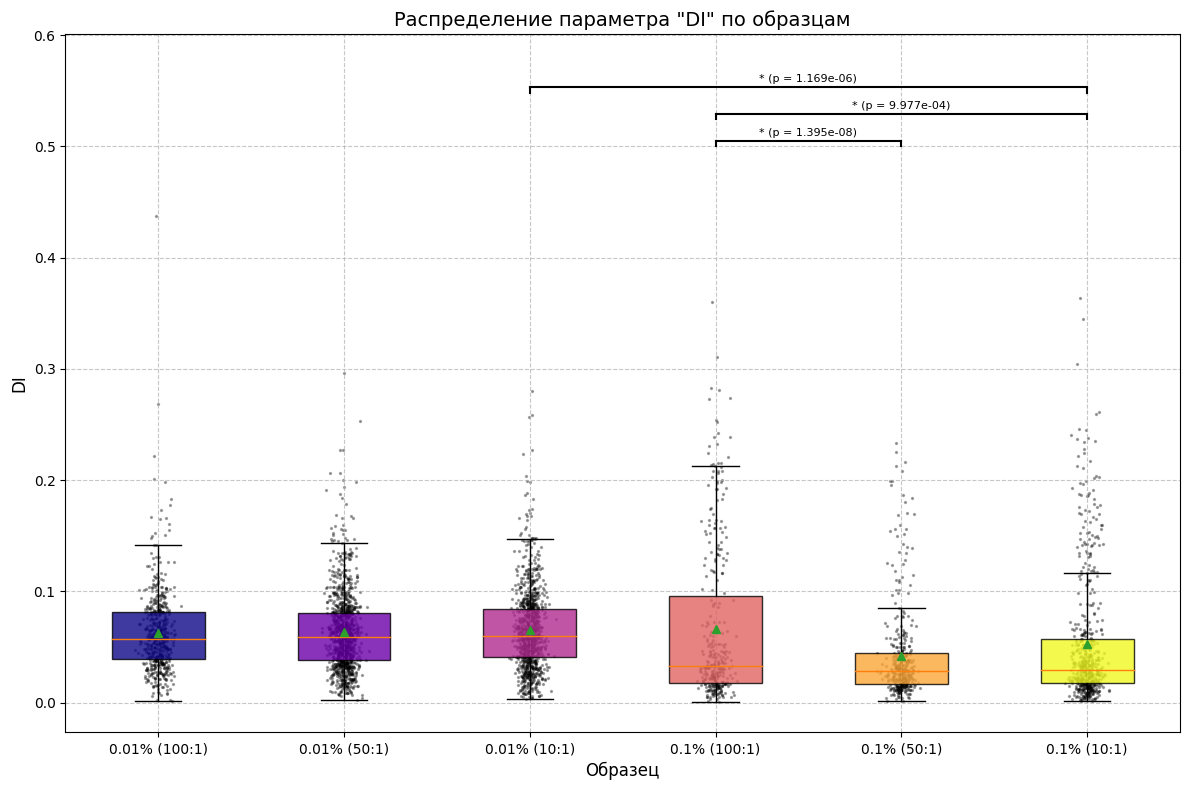

In [45]:
fig, ax = plot_boxplots_with_ttest_percent(
    data_traces,
    'DI',
    pairs_to_compare=[['0.1% (100:1)', '0.1% (50:1)'], ['0.1% (100:1)', '0.1% (10:1)'], ['0.01% (10:1)', '0.1% (10:1)']],
    difference_percent=1,
    sample_names=['0.01% (100:1)', '0.01% (50:1)', '0.01% (10:1)', '0.1% (100:1)', '0.1% (50:1)', '0.1% (10:1)']
)
plt.show()

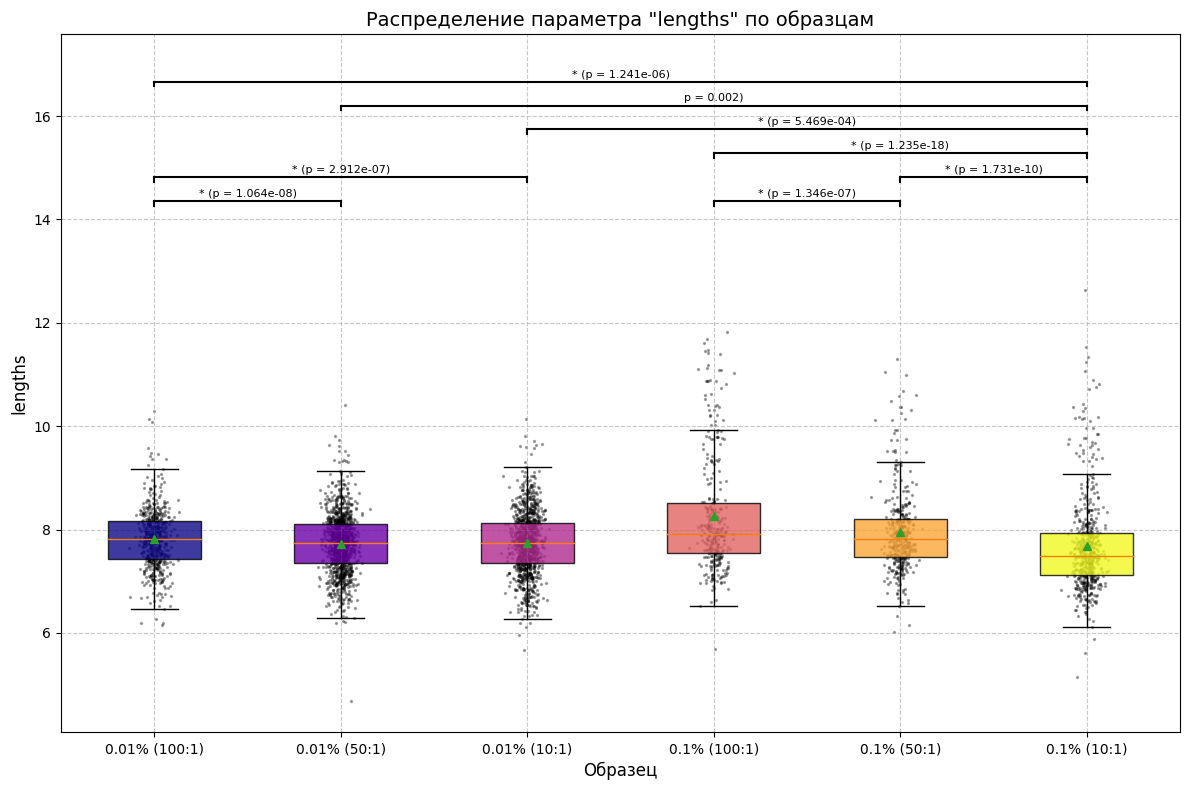

In [49]:
fig, ax = plot_boxplots_with_ttest_percent(
    data_traces,
    'lengths',
    # pairs_to_compare=[['0.1% (100:1)', '0.1% (50:1)'], ['0.1% (100:1)', '0.1% (10:1)'], ['0.01% (10:1)', '0.1% (10:1)']],
    difference_percent=1,
    sample_names=['0.01% (100:1)', '0.01% (50:1)', '0.01% (10:1)', '0.1% (100:1)', '0.1% (50:1)', '0.1% (10:1)']
)
plt.show()

# Применение EM-алгоритма

In [140]:
data_traces = load_traces(r'E:\Flow chamber analysis\2025-03-14 Glytar analysis 3\2025-03-12 all.xlsx')

In [45]:
def em_algorithm_with_elbow(trace, parameter_name, title, max_components=10, penalty_coef=0.1):
    # Построение исходных данных (всегда красной)
    # plt.hist(trace, bins=30, density=True, alpha=0.3, color='red', label='Исходное распределение')
    x, y = kde_plot(trace)
    plt.plot(x, y, color='black', label='Исходное распределение')
    
    # Вычисление BIC для разного количества компонент с учетом штрафа
    bic = []
    for n_components in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(trace.reshape(-1, 1))
        bic.append(gmm.bic(trace.reshape(-1, 1)) + penalty_coef * n_components)
    
    # Использование KneeLocator для нахождения "локтя"
    knee_locator = KneeLocator(range(1, max_components + 1), bic, curve='convex', direction='decreasing')
    optimal_components = knee_locator.elbow
    print(f"Оптимальное количество компонент: {optimal_components}")
    
    # Если KneeLocator не нашёл локоть, используем минимальное значение BIC
    if optimal_components is None:
        optimal_components = np.argmin(bic) + 1
        print(f"Локоть не найден, используется минимальное BIC: {optimal_components}")
    
    # Обучение GMM с оптимальным количеством компонент
    gmm = GaussianMixture(n_components=optimal_components, random_state=0)
    gmm.fit(trace.reshape(-1, 1))
    
    # Генерация точек для построения графиков
    x = np.linspace(min(trace), max(trace), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    
    # Построение суммарного распределения
    plt.plot(x, pdf, label='Суммарное распределение', color='red')
    
    # Увеличение верхнего предела оси Y для корректного отображения подписей
    plt.ylim(top=max(pdf) * 1.5)  # Увеличиваем верхний предел на 50% от максимального значения распределения
    
    # Построение отдельных компонент
    for i in range(optimal_components):
        mean = gmm.means_[i][0]
        std = np.sqrt(gmm.covariances_[i][0])
        weight = gmm.weights_[i]
        component_pdf = weight * norm.pdf(x, mean, std)
        mean, std, weight = float(mean), float(std), float(weight)
        plt.plot(x, component_pdf, ls='--', label=f'Компонента {i+1}')
        
        # Позиция текста над пиком
        y_text = max(component_pdf) * 1.3  # Поднимаем текст на 30% выше пика
        y_text = min(y_text, plt.ylim()[1] * 0.85)  # Ограничиваем, чтобы текст не выходил за рамки
        plt.text(mean, y_text, 
                 f'μ={mean:.2f}\nσ={std:.2f}\nw={weight:.2f}', 
                 horizontalalignment='center',
                 fontsize=9)  # Уменьшаем шрифт
    

    plt.title(title)
    plt.xlabel(parameter_name)
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.show()
    
    # Создание датафрейма с информацией о пиках
    peaks_info = pd.DataFrame({
        'Среднее': gmm.means_.flatten(),
        'Стандартное отклонение': np.sqrt(gmm.covariances_.flatten()),
        'Доля': gmm.weights_
    })
    print(peaks_info)

Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_5040\2296387479.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


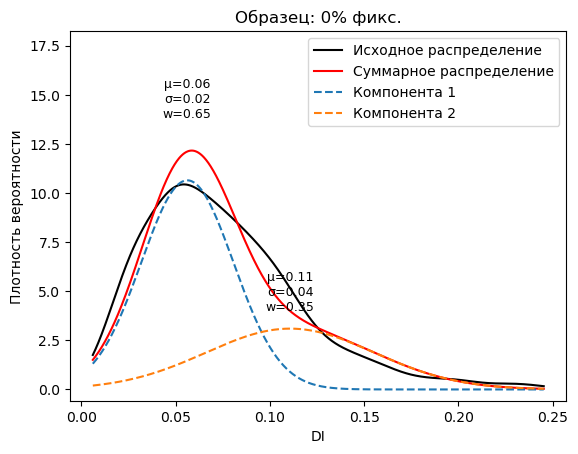

    Среднее  Стандартное отклонение      Доля
0  0.056183                0.024504  0.653615
1  0.110699                0.044639  0.346385
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_5040\2296387479.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


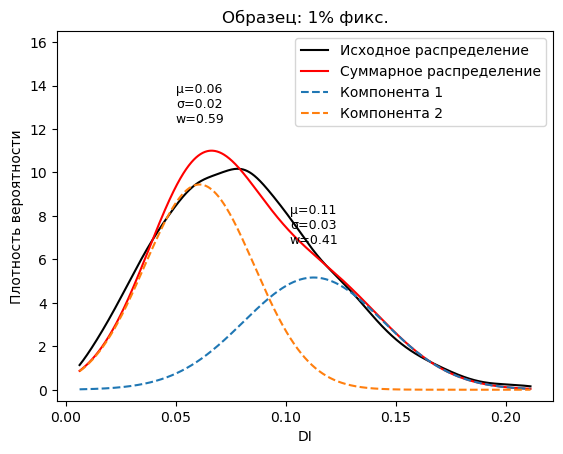

    Среднее  Стандартное отклонение      Доля
0  0.112521                 0.03181  0.411869
1  0.060660                 0.02484  0.588131
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_5040\2296387479.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


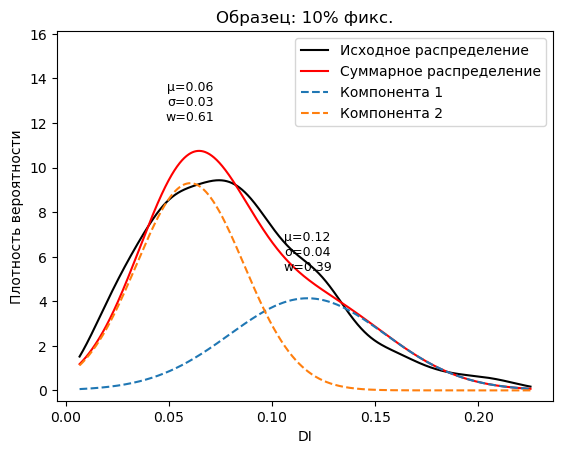

    Среднее  Стандартное отклонение      Доля
0  0.117207                0.037842  0.392099
1  0.060344                0.026081  0.607901
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_5040\2296387479.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


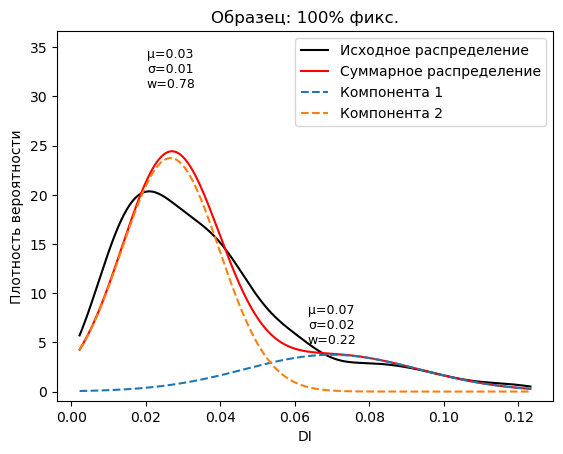

    Среднее  Стандартное отклонение      Доля
0  0.069894                0.023383  0.219193
1  0.026650                0.013125  0.780807
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_5040\2296387479.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


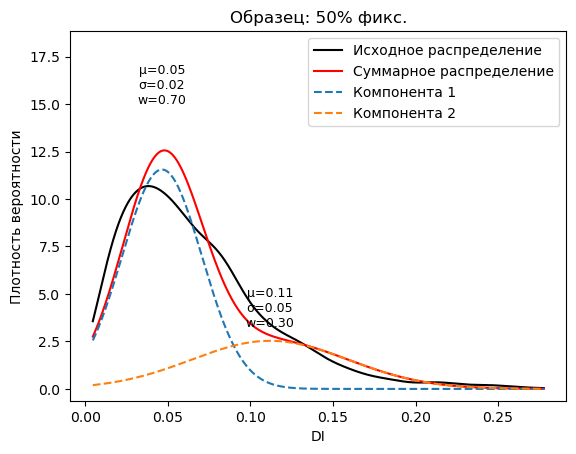

    Среднее  Стандартное отклонение      Доля
0  0.046431                0.024108  0.698073
1  0.111751                0.047578  0.301927


In [57]:
for measurement in data_traces.keys():
    em_algorithm_with_elbow(
        data_traces[measurement]["DI"],
        "DI",
        "Образец: " + measurement + " фикс.",
        max_components=2
    )

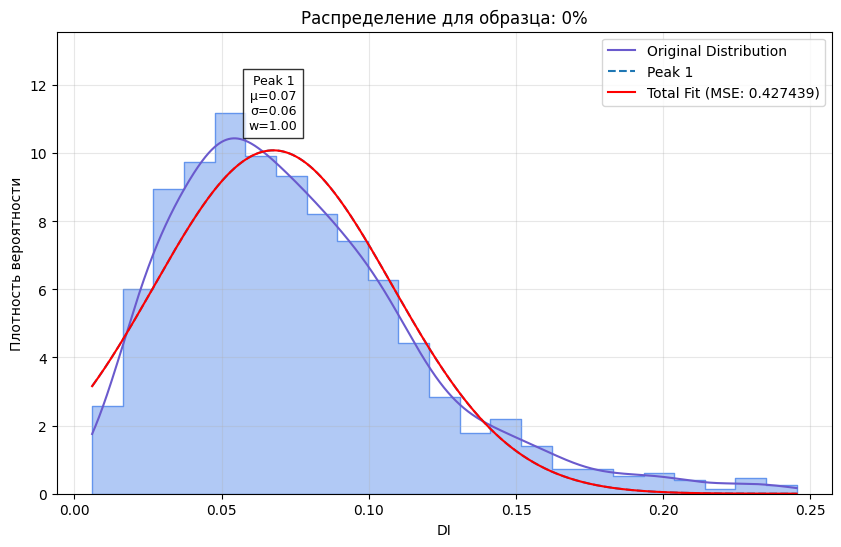

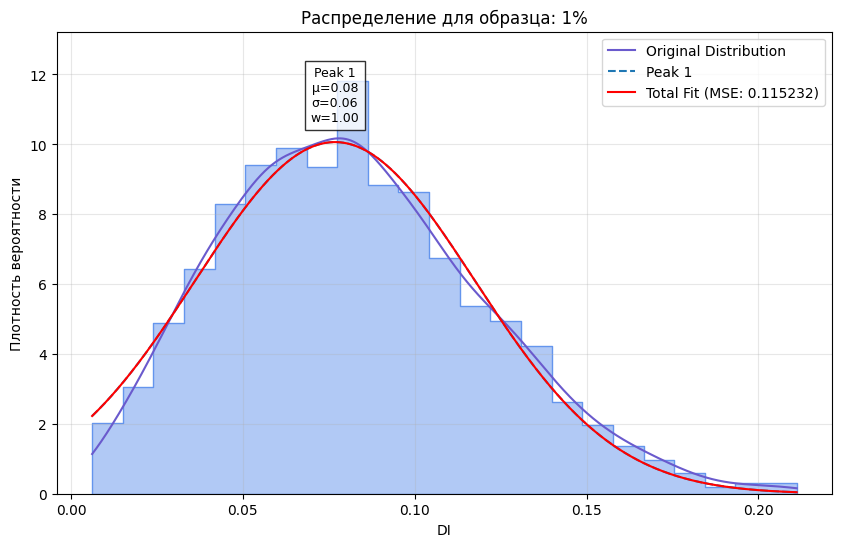

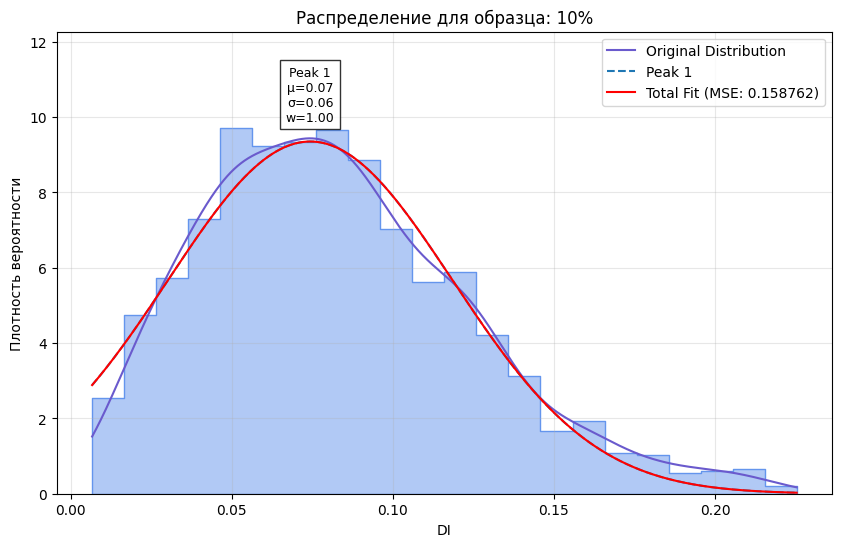

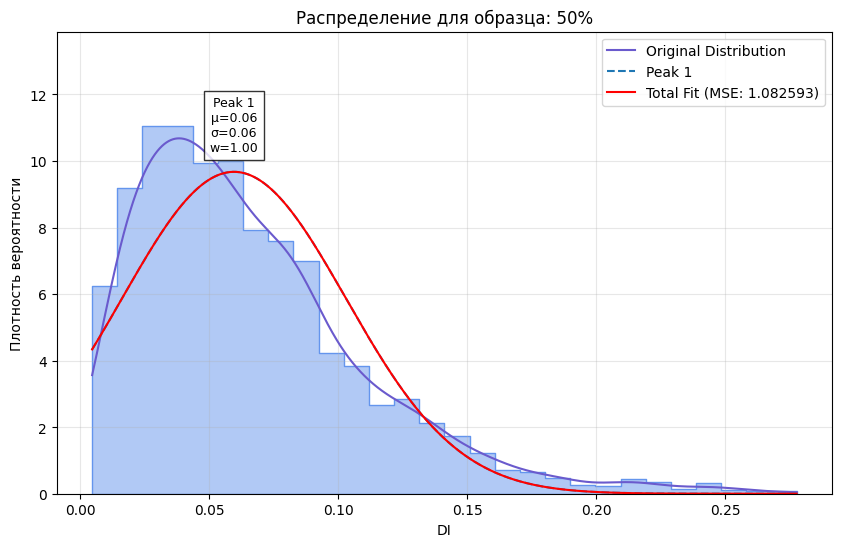

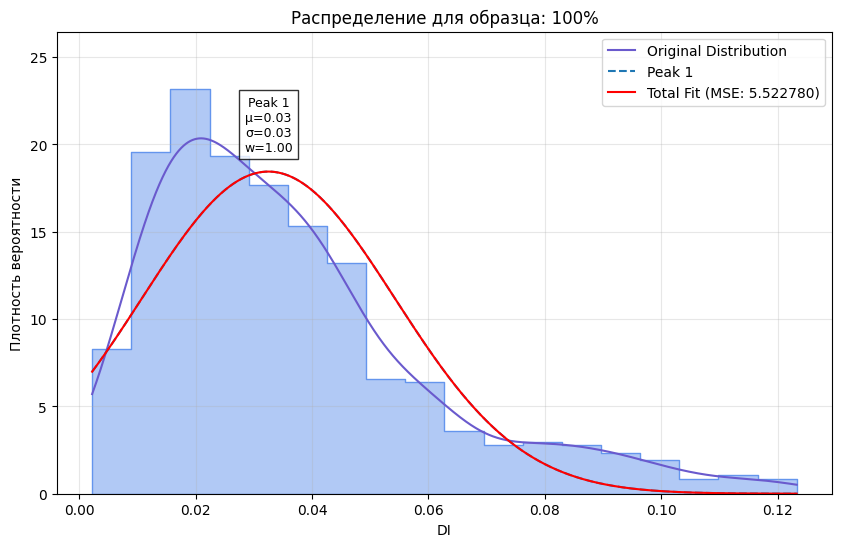

Средняя квадратичная ошибка для каждого измерения:
0%: 0.427439
1%: 0.115232
10%: 0.158762
50%: 1.082593
100%: 5.522780

Результаты анализа пиков:
  measurement  peak_number      mean    stddev  weight  amplitude
0          0%            1  0.067560  0.057121     1.0  10.082578
1          1%            1  0.076792  0.057512     1.0  10.061526
2         10%            1  0.074376  0.062412     1.0   9.346121
3         50%            1  0.059537  0.061400     1.0   9.673257
4        100%            1  0.032516  0.030734     1.0  18.442789


In [167]:
analyse_peaks(
    data_traces,
    parameter='DI',
    sample_names = ['0%', '1%', '10%', '50%', '100%'],
    save_name = '2025-03-12 peak weights (1)',
    n_components=1,
    n_as_max=False,
    EM=True,
    optimise=True
)

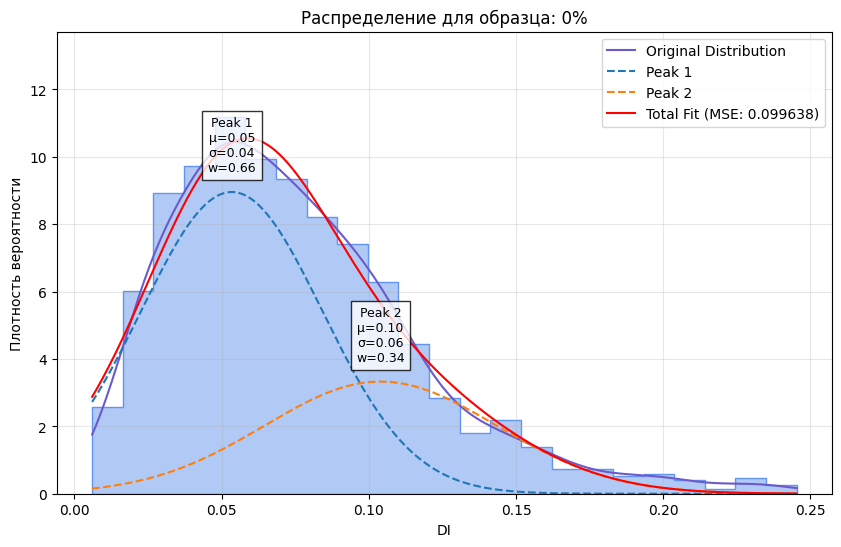

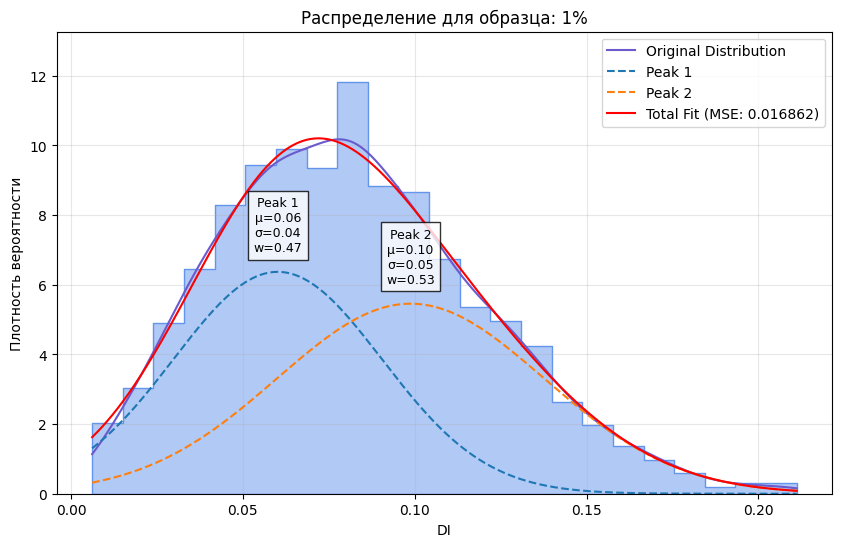

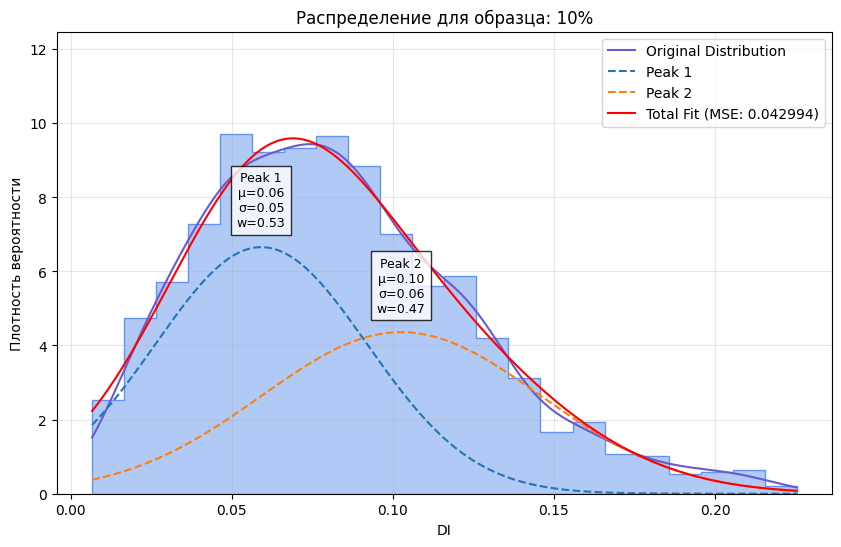

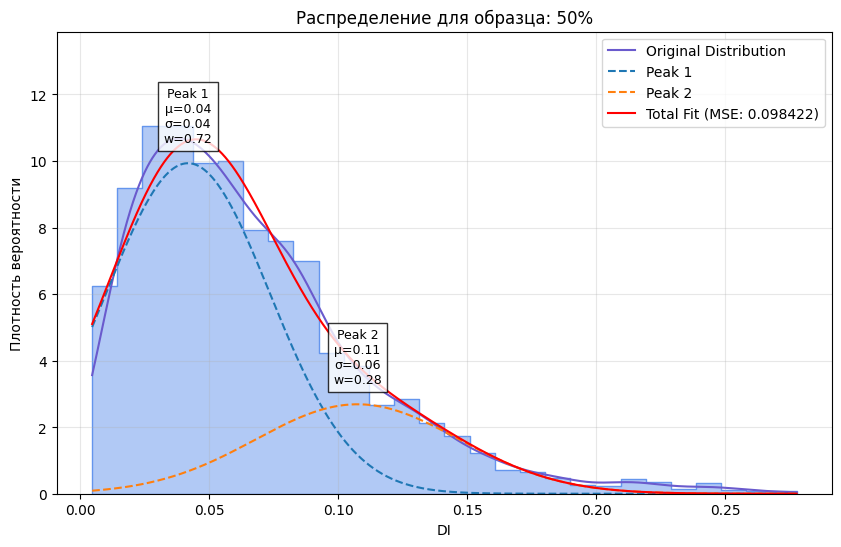

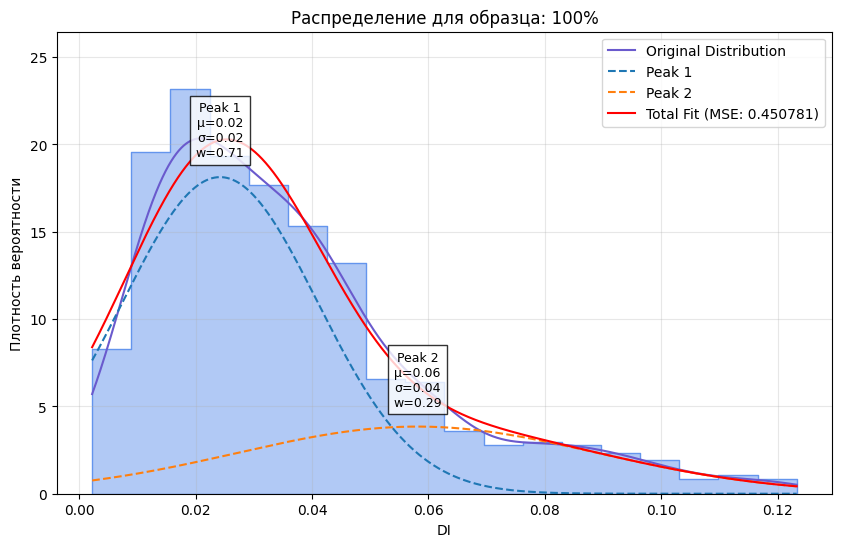

Средняя квадратичная ошибка для каждого измерения:
0%: 0.099638
1%: 0.016862
10%: 0.042994
50%: 0.098422
100%: 0.450781

Результаты анализа пиков:
  measurement  peak_number      mean    stddev    weight  amplitude
0          0%            1  0.053441  0.043466  0.664391   8.951609
1          0%            2  0.103987  0.055833  0.335609   3.326534
2          1%            1  0.060131  0.042880  0.469747   6.366237
3          1%            2  0.098785  0.054976  0.530253   5.452488
4         10%            1  0.059178  0.046455  0.526418   6.652496
5         10%            2  0.102594  0.061245  0.473582   4.358204
6         50%            1  0.041691  0.044898  0.723922   9.931715
7         50%            2  0.107406  0.055878  0.276078   2.687787
8        100%            1  0.024218  0.023633  0.708621  18.126047
9        100%            2  0.058112  0.043861  0.291379   3.844011


In [168]:
analyse_peaks(
    data_traces,
    parameter='DI',
    sample_names = ['0%', '1%', '10%', '50%', '100%'],
    save_name = '2025-03-12 peak weights (2)',
    n_components=2,
    n_as_max=False,
    EM=True,
    optimise=True
)

## Бокс-плоты

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib.patches import FancyArrowPatch, Rectangle, ConnectionStyle
import pandas as pd
from matplotlib.path import Path
import matplotlib.patheffects as PathEffects

def plot_boxplots_with_ttest(data_traces, parameter, sample_names=None, figsize=(12, 8), alpha=0.05):
    """
    Создает боксплоты для выбранного параметра для каждого измерения с аннотациями
    статистической значимости по тесту Стьюдента.
    
    Parameters:
    -----------
    data_traces : dict
        Словарь, где ключи - это идентификаторы образцов, а значения - словари с параметрами.
        Каждый параметр (lengths, areas, EI, DI и т.д.) - это список значений.
    parameter : str
        Название параметра для визуализации (например, 'lengths', 'areas', 'EI').
    figsize : tuple, optional
        Размер графика (ширина, высота) в дюймах.
    alpha : float, optional
        Уровень значимости для теста Стьюдента (по умолчанию 0.05).
    
    Returns:
    --------
    fig, ax : tuple
        Объекты matplotlib для дальнейшей настройки графика при необходимости.
    """
    
    # Извлечем данные для выбранного параметра
    if sample_names==None:
        sample_names = list(data_traces.keys())
    
    # Проверяем существование параметра в каждом образце и преобразуем в списки
    data_for_boxplot = []
    valid_sample_names = []
    
    for sample in sample_names:
        if parameter in data_traces[sample] and data_traces[sample][parameter] is not None:
            # Преобразуем в список, если данные в numpy массиве
            data = data_traces[sample][parameter]
            if isinstance(data, np.ndarray):
                data = data.tolist()
            
            # Проверяем, что данные не пустые
            if len(data) > 0:
                data_for_boxplot.append(data)
                valid_sample_names.append(sample)
    
    # Проверяем, есть ли данные для построения
    if not data_for_boxplot:
        raise ValueError(f"Нет данных для параметра '{parameter}' ни в одном из образцов")
    
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=figsize)
    
    # Строим боксплоты (используем tick_labels вместо labels)
    bp = ax.boxplot(data_for_boxplot, patch_artist=True, showfliers=False, showmeans=True, tick_labels=valid_sample_names)
    
    # Настраиваем цвета боксплотов
    colors = plt.cm.plasma(np.linspace(0, 1, len(valid_sample_names)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    # Добавляем точки данных
    for i, data in enumerate(data_for_boxplot):
        # Добавляем небольшой шум по оси x для лучшей визуализации
        x = np.random.normal(i+1, 0.04, size=len(data))
        ax.scatter(x, data, s=2, c='black', alpha=0.3)
    
    # Настройка графика
    ax.set_title(f'Распределение параметра "{parameter}" по образцам', fontsize=14)
    ax.set_xlabel('Образец', fontsize=12)
    ax.set_ylabel(parameter, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Находим минимальное и максимальное значения для всех данных
    all_values = [val for sublist in data_for_boxplot for val in sublist]
    if not all_values:
        raise ValueError(f"Нет данных для параметра '{parameter}'")
    
    y_max = max(all_values) * 1.1
    y_min = min(all_values)
    y_range = y_max - y_min
    
    # Проводим тесты Стьюдента и собираем значимые результаты
    n_samples = len(valid_sample_names)
    significant_pairs = []
    
    for i in range(n_samples - 1):
        for j in range(i + 1, n_samples):
            # Проводим тест Стьюдента
            sample1 = data_for_boxplot[i]
            sample2 = data_for_boxplot[j]
            
            # Проверяем, что данные не пустые
            if not sample1 or not sample2:
                continue
            
            # Преобразуем в массивы numpy, если они еще не являются таковыми
            sample1_array = np.array(sample1)
            sample2_array = np.array(sample2)
            
            # Проверка на NaN значения
            sample1_array = sample1_array[~np.isnan(sample1_array)]
            sample2_array = sample2_array[~np.isnan(sample2_array)]
            
            if len(sample1_array) == 0 or len(sample2_array) == 0:
                continue
            
            u_stat, p_value = stats.ttest_ind(sample1_array, sample2_array, alternative='two-sided', equal_var=False)
            
            # Если p-значение меньше alpha, добавляем пару в список значимых результатов
            if p_value < alpha:
                significant_pairs.append((i, j, p_value))
    
    # Сортируем пары по расстоянию между образцами (сначала ближайшие)
    significant_pairs.sort(key=lambda x: x[1] - x[0])
    
    # Определяем высоту для каждой аннотации
    height_step = y_range * 0.05 # Было 0.07
    
    # Структура для отслеживания занятых интервалов
    # Каждый элемент - это кортеж (x_start, x_end, height)
    occupied_intervals = []
    
    # Функция для проверки пересечения интервалов
    def intervals_overlap(interval1, interval2):
        # Проверяет, пересекаются ли два интервала
        a_start, a_end = interval1
        b_start, b_end = interval2
        return max(a_start, b_start) <= min(a_end, b_end)
    
    # Функция для определения высоты аннотации
    def get_annotation_height(x_start, x_end):
        # Начнем с минимальной высоты
        height = y_max + height_step
        
        # Проверим все занятые интервалы
        while True:
            # Найдем все интервалы, которые пересекаются с нашим на текущей высоте
            overlapping = [h for x1, x2, h in occupied_intervals 
                          if h == height and intervals_overlap((x_start, x_end), (x1, x2))]
            
            if not overlapping:
                # Если нет пересечений, используем эту высоту
                return height
            else:
                # Иначе пробуем следующий уровень
                height += height_step
    
    # Добавляем аннотации для значимых пар
    for i, j, p_value in significant_pairs:
        # Определяем интервал по оси X
        x_start = i + 1  # +1 потому что индексы боксплотов начинаются с 1
        x_end = j + 1
        
        # Находим подходящую высоту для аннотации
        height = get_annotation_height(x_start, x_end)
        
        # Добавляем интервал в список занятых
        occupied_intervals.append((x_start, x_end, height))
        
        # Рисуем горизонтальную линию
        ax.plot([x_start, x_end], [height, height], 'k-', lw=1.5)
        
        # Добавляем вертикальные линии (усы) только снизу
        bar_length = height_step * 0.2  # Длина уса
        ax.plot([x_start, x_start], [height, height - bar_length], 'k-', lw=1.5)
        ax.plot([x_end, x_end], [height, height - bar_length], 'k-', lw=1.5)
        
        # Добавляем прямоугольник с p-значением
        p_text = f"* (p = {p_value:.3e})" if p_value < 0.001 else f"p = {p_value:.3f})"
        rx, ry = (x_start + x_end) / 2, height + height_step * 0.3
        # rect = Rectangle((rx - 0.4, ry - height_step * 0.25), 0.8, height_step * 0.5, 
                        # facecolor='white', edgecolor='black', alpha=0.8)
        # ax.add_patch(rect)
        ax.text(rx, ry, p_text, ha='center', va='center', fontsize=8)
    
    # Устанавливаем пределы оси y с учетом аннотаций
    if occupied_intervals:
        max_height = max([h for _, _, h in occupied_intervals])
        ax.set_ylim(ax.get_ylim()[0], max_height + height_step * 2)
    
    plt.tight_layout()
    return fig, ax

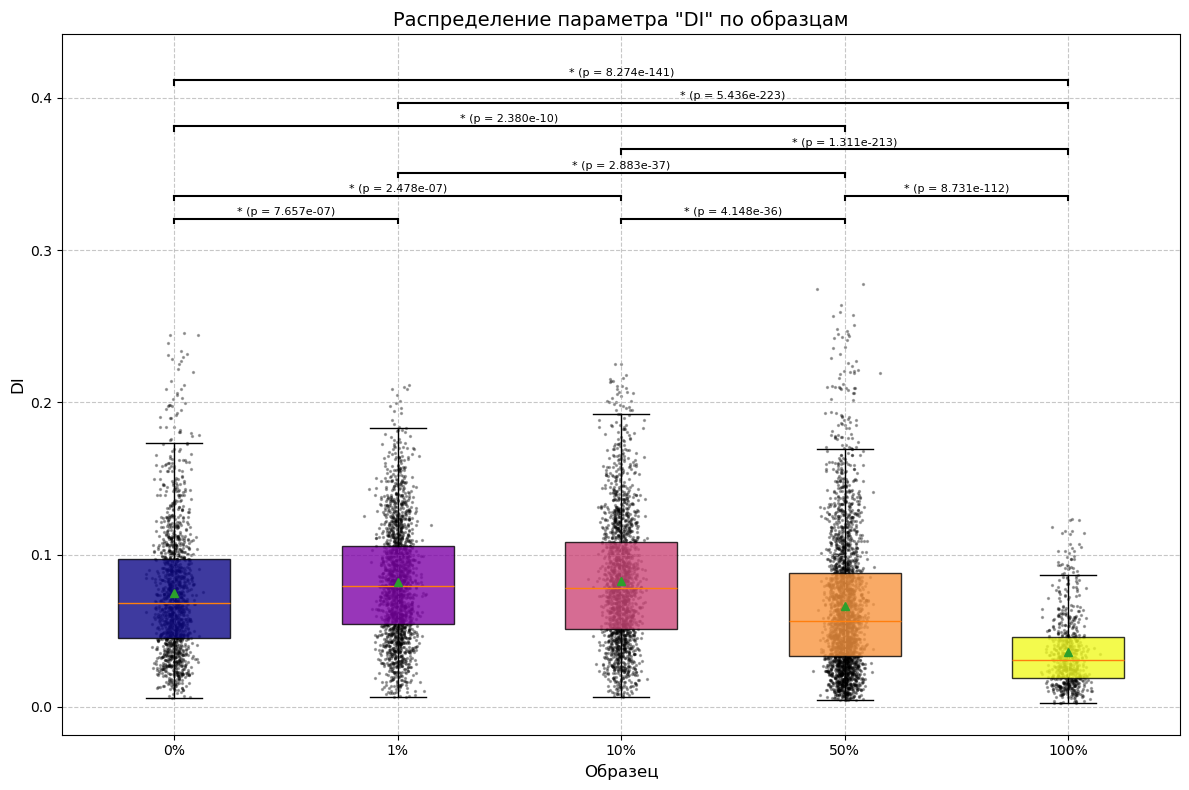

In [31]:
fig, ax = plot_boxplots_with_ttest(data_traces, 'DI', sample_names=['0%', '1%', '10%', '50%', '100%'])
plt.show()

### Тест на 10%

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib.patches import FancyArrowPatch, Rectangle, ConnectionStyle
import pandas as pd
from matplotlib.path import Path
import matplotlib.patheffects as PathEffects

def ttest(sample1, sample2, difference_percent):
    # Преобразуем в массивы numpy, если они еще не являются таковыми
    sample1_array = np.array(sample1)
    sample2_array = np.array(sample2)
    
    # Проверка на NaN значения
    sample1_array = sample1_array[~np.isnan(sample1_array)]
    sample2_array = sample2_array[~np.isnan(sample2_array)]
    
    if len(sample1_array) == 0 or len(sample2_array) == 0:
        print('Error: массивые заполнены nan')
        return

    # считаем среднее
    sample1_mean = np.mean(sample1_array)
    sample2_mean = np.mean(sample2_array)

    # рассчитываем смещение
    if difference_percent > 0:
        max_diff = np.mean((sample1_mean, sample2_mean)) * (difference_percent) / 100
        delta = max_diff if sample1_mean < sample2_mean else -max_diff
    else:
        delta = 0
    
    u_stat, p_value = stats.ttest_ind(sample1_array, sample2_array + delta, alternative='greater', equal_var=False)
    return u_stat, p_value

def plot_boxplots_with_ttest_percent(data_traces, parameter, pairs_to_compare=None, difference_percent=10, sample_names=None, figsize=(12, 8), alpha=0.05):
    """
    Создает боксплоты для выбранного параметра для каждого измерения с аннотациями
    статистической значимости по тесту Стьюдента.
    
    Parameters:
    -----------
    data_traces : dict
        Словарь, где ключи - это идентификаторы образцов, а значения - словари с параметрами.
        Каждый параметр (lengths, areas, EI, DI и т.д.) - это список значений.
    parameter : str
        Название параметра для визуализации (например, 'lengths', 'areas', 'EI').
    figsize : tuple, optional
        Размер графика (ширина, высота) в дюймах.
    alpha : float, optional
        Уровень значимости для теста Стьюдента (по умолчанию 0.05).
    
    Returns:
    --------
    fig, ax : tuple
        Объекты matplotlib для дальнейшей настройки графика при необходимости.
    """
    
    # Извлечем данные для выбранного параметра
    if sample_names==None:
        sample_names = list(data_traces.keys())
    
    # Проверяем существование параметра в каждом образце и преобразуем в списки
    data_for_boxplot = []
    valid_sample_names = []
    
    for sample in sample_names:
        if parameter in data_traces[sample] and data_traces[sample][parameter] is not None:
            # Преобразуем в список, если данные в numpy массиве
            data = data_traces[sample][parameter]
            if isinstance(data, np.ndarray):
                data = data.tolist()
            
            # Проверяем, что данные не пустые
            if len(data) > 0:
                data_for_boxplot.append(data)
                valid_sample_names.append(sample)
    
    # Проверяем, есть ли данные для построения
    if not data_for_boxplot:
        raise ValueError(f"Нет данных для параметра '{parameter}' ни в одном из образцов")
    
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=figsize)
    
    # Строим боксплоты (используем tick_labels вместо labels)
    bp = ax.boxplot(data_for_boxplot, patch_artist=True, showfliers=False, showmeans=True, labels=valid_sample_names)
    
    # Настраиваем цвета боксплотов
    colors = plt.cm.plasma(np.linspace(0, 1, len(valid_sample_names)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    # Добавляем точки данных
    for i, data in enumerate(data_for_boxplot):
        # Добавляем небольшой шум по оси x для лучшей визуализации
        x = np.random.normal(i+1, 0.04, size=len(data))
        ax.scatter(x, data, s=2, c='black', alpha=0.3)
    
    # Настройка графика
    ax.set_title(f'Распределение параметра "{parameter}" по образцам', fontsize=14)
    ax.set_xlabel('Образец', fontsize=12)
    ax.set_ylabel(parameter, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Находим минимальное и максимальное значения для всех данных
    all_values = [val for sublist in data_for_boxplot for val in sublist]
    if not all_values:
        raise ValueError(f"Нет данных для параметра '{parameter}'")
    
    y_max = max(all_values) * 1.1
    y_min = min(all_values)
    y_range = y_max - y_min
    
    # Проводим тесты Стьюдента и собираем значимые результаты
    n_samples = len(valid_sample_names)
    significant_pairs = []

    if pairs_to_compare == None:
        for i in range(n_samples - 1):
            for j in range(i + 1, n_samples):
                # Проводим тест Стьюдента
                sample1 = data_for_boxplot[i]
                sample2 = data_for_boxplot[j]

                # Проверяем, что данные не пустые
                if not sample1 or not sample2:
                    continue

                u_stat, p_value = ttest(sample1, sample2, difference_percent)
                
                # Если p-значение меньше alpha, добавляем пару в список значимых результатов
                if p_value < alpha:
                    significant_pairs.append((i, j, p_value))
    else:
        for name_i, name_j in pairs_to_compare:
            i = valid_sample_names.index(name_i)
            j = valid_sample_names.index(name_j)

            sample1 = data_for_boxplot[i]
            sample2 = data_for_boxplot[j]

            # Проверяем, что данные не пустые
            if not sample1 or not sample2:
                continue

            u_stat, p_value = ttest(sample1, sample2, difference_percent)
            significant_pairs.append((i, j, p_value))
            
    
    # Сортируем пары по расстоянию между образцами (сначала ближайшие)
    significant_pairs.sort(key=lambda x: x[1] - x[0])
    
    # Определяем высоту для каждой аннотации
    height_step = y_range * 0.05 # Было 0.07
    
    # Структура для отслеживания занятых интервалов
    # Каждый элемент - это кортеж (x_start, x_end, height)
    occupied_intervals = []
    
    # Функция для проверки пересечения интервалов
    def intervals_overlap(interval1, interval2):
        # Проверяет, пересекаются ли два интервала
        a_start, a_end = interval1
        b_start, b_end = interval2
        return max(a_start, b_start) <= min(a_end, b_end)
    
    # Функция для определения высоты аннотации
    def get_annotation_height(x_start, x_end):
        # Начнем с минимальной высоты
        height = y_max + height_step
        
        # Проверим все занятые интервалы
        while True:
            # Найдем все интервалы, которые пересекаются с нашим на текущей высоте
            overlapping = [h for x1, x2, h in occupied_intervals 
                          if h == height and intervals_overlap((x_start, x_end), (x1, x2))]
            
            if not overlapping:
                # Если нет пересечений, используем эту высоту
                return height
            else:
                # Иначе пробуем следующий уровень
                height += height_step
    
    # Добавляем аннотации для значимых пар
    for i, j, p_value in significant_pairs:
        # Определяем интервал по оси X
        x_start = i + 1  # +1 потому что индексы боксплотов начинаются с 1
        x_end = j + 1
        
        # Находим подходящую высоту для аннотации
        height = get_annotation_height(x_start, x_end)
        
        # Добавляем интервал в список занятых
        occupied_intervals.append((x_start, x_end, height))
        
        # Рисуем горизонтальную линию
        ax.plot([x_start, x_end], [height, height], 'k-', lw=1.5)
        
        # Добавляем вертикальные линии (усы) только снизу
        bar_length = height_step * 0.2  # Длина уса
        ax.plot([x_start, x_start], [height, height - bar_length], 'k-', lw=1.5)
        ax.plot([x_end, x_end], [height, height - bar_length], 'k-', lw=1.5)
        
        # Добавляем прямоугольник с p-значением
        p_text = f"* (p = {p_value:.3e})" if p_value < 0.001 else f"p = {p_value:.3f})"
        rx, ry = (x_start + x_end) / 2, height + height_step * 0.3
        # rect = Rectangle((rx - 0.4, ry - height_step * 0.25), 0.8, height_step * 0.5, 
                        # facecolor='white', edgecolor='black', alpha=0.8)
        # ax.add_patch(rect)
        ax.text(rx, ry, p_text, ha='center', va='center', fontsize=8)
    
    # Устанавливаем пределы оси y с учетом аннотаций
    if occupied_intervals:
        max_height = max([h for _, _, h in occupied_intervals])
        ax.set_ylim(ax.get_ylim()[0], max_height + height_step * 2)
    
    plt.tight_layout()
    return fig, ax

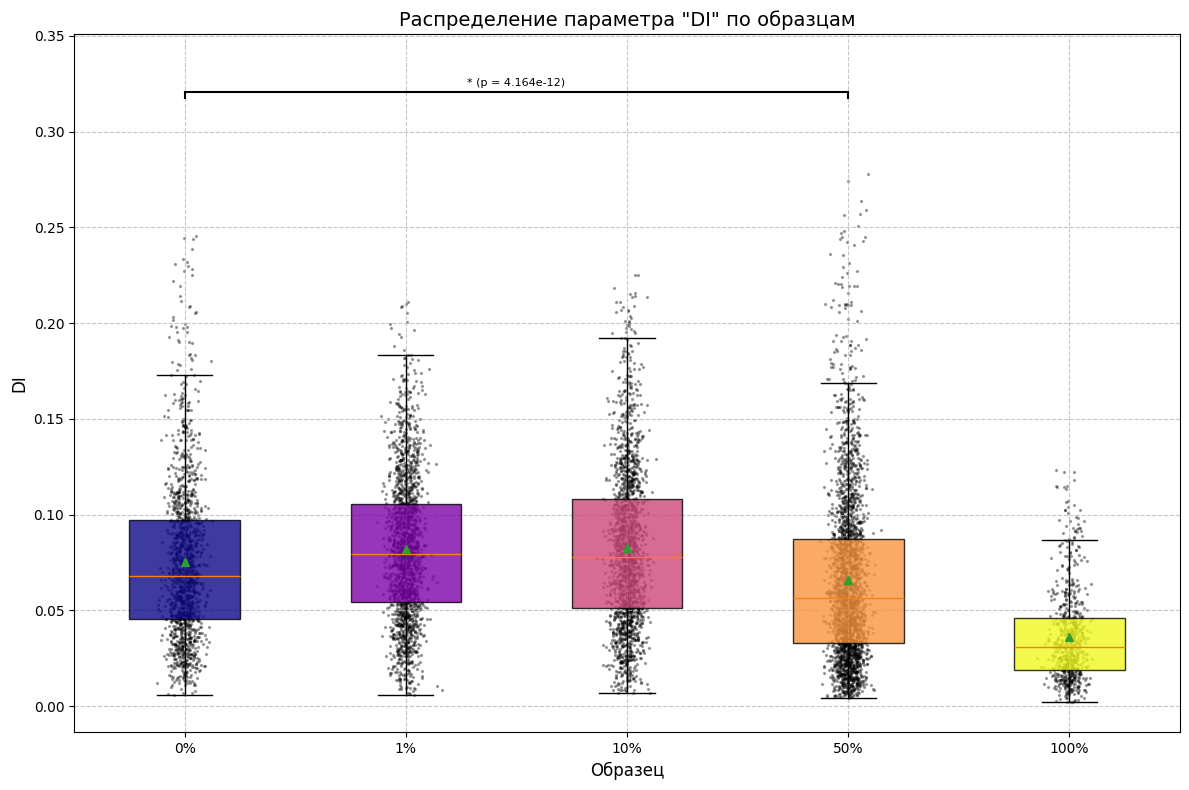

In [166]:
fig, ax = plot_boxplots_with_ttest_percent(
    data_traces,
    'DI',
    pairs_to_compare=[['0%', '50%']],
    difference_percent=1,
    sample_names=['0%', '1%', '10%', '50%', '100%']
)
plt.show()

# Старое измерение (усовершенствовал функцию)

2024-12-06

Кровь из пальца

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:25<00:00, 113.09s/it]


                     0%          1%         10%          50%         100%
cell_count   952.000000  634.000000  905.000000  1207.000000  1510.000000
length_mean    9.442929    8.856956    9.395312     8.602804     7.576577
area_mean     45.144048   46.399045   47.492649    44.599201    40.613392
EI_mean        1.528667    1.322143    1.440435     1.298868     1.114752
DI_mean        0.205135    0.130980    0.174393     0.121654     0.052288
DI_std         0.054995    0.080840    0.071034     0.082944     0.040777
DI_w           0.121865    0.236429    0.120255     0.214756     0.059375
DI_BC          0.308188    0.467503    0.331399     0.524105     0.580966
DI_KC          0.554769    0.671780    0.549158     0.647894     0.654730


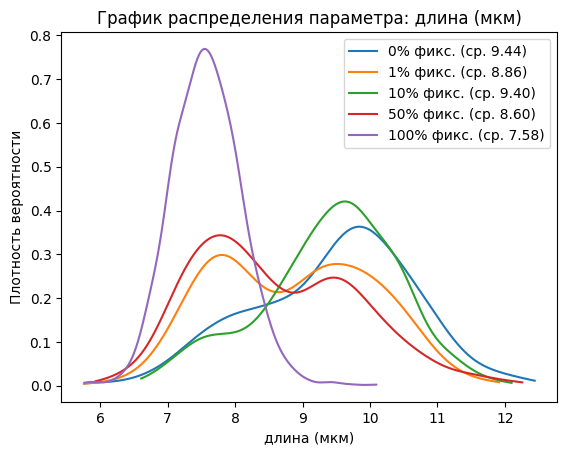

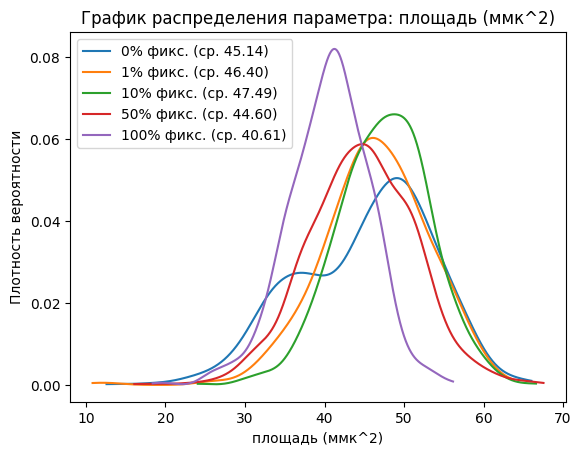

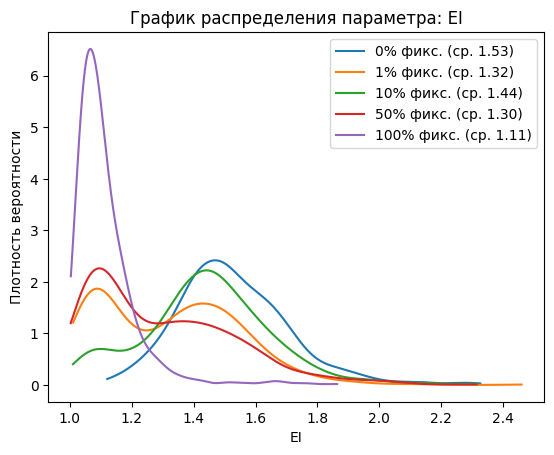

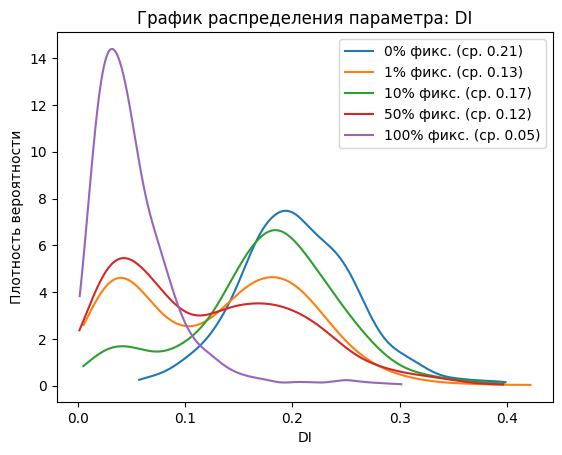

In [13]:
data = {
    "0%" : r"E:\Flow chamber\Ladynin\2024-12-06-flow chamber\norm",
    "1%" : r"E:\Flow chamber\Ladynin\2024-12-06-flow chamber\gly 1",
    "10%" : r"E:\Flow chamber\Ladynin\2024-12-06-flow chamber\gly 10",
    "50%" : r"E:\Flow chamber\Ladynin\2024-12-06-flow chamber\gly 50",
    "100%" : r"E:\Flow chamber\Ladynin\2024-12-06-flow chamber\gly 100"
}

_, data_traces = analyse_files(
    data,
    model,
    percent=0.001,
    calculations_name='2025-03-12 all old',
    summary_name='2025-03-12 summary old'
)

draw_graphs(
    data_traces,
    legend=[i + " фикс." for i in data.keys()]
)

## Применение EM-алгоритма

In [169]:
data_traces = load_traces(r'E:\Flow chamber analysis\2025-03-14 Glytar analysis 3\2025-03-12 all old.xlsx')

In [5]:
def em_algorithm_with_elbow(trace, parameter_name, title, max_components=10, penalty_coef=0.1):
    # Вычисление BIC для разного количества компонент с учетом штрафа
    bic = []
    for n_components in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(trace.reshape(-1, 1))
        bic.append(gmm.bic(trace.reshape(-1, 1)) + penalty_coef * n_components)
    
    # Использование KneeLocator для нахождения "локтя"
    knee_locator = KneeLocator(range(1, max_components + 1), bic, curve='convex', direction='decreasing')
    optimal_components = knee_locator.elbow
    print(f"Оптимальное количество компонент: {optimal_components}")
    
    # Если KneeLocator не нашёл локоть, используем минимальное значение BIC
    if optimal_components is None:
        optimal_components = np.argmin(bic) + 1
        print(f"Локоть не найден, используется минимальное BIC: {optimal_components}")
    
    # Обучение GMM с оптимальным количеством компонент
    gmm = GaussianMixture(n_components=optimal_components, random_state=0)
    gmm.fit(trace.reshape(-1, 1))
    
    # Генерация точек для построения графиков
    x = np.linspace(min(trace), max(trace), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    
    # Построение исходного распределения
    plt.plot(x, pdf, label='Суммарное распределение', color='black')
    
    # Увеличение верхнего предела оси Y для корректного отображения подписей
    plt.ylim(top=max(pdf) * 1.5)  # Увеличиваем верхний предел на 50% от максимального значения распределения
    
    # Построение отдельных компонент
    for i in range(optimal_components):
        mean = gmm.means_[i][0]
        std = np.sqrt(gmm.covariances_[i][0])
        weight = gmm.weights_[i]
        component_pdf = weight * norm.pdf(x, mean, std)
        mean, std, weight = float(mean), float(std), float(weight)
        plt.plot(x, component_pdf, label=f'Компонента {i+1}')
        
        # Позиция текста над пиком
        y_text = max(component_pdf) * 1.3  # Поднимаем текст на 30% выше пика
        y_text = min(y_text, plt.ylim()[1] * 0.85)  # Ограничиваем, чтобы текст не выходил за рамки
        plt.text(mean, y_text, 
                 f'μ={mean:.2f}\nσ={std:.2f}\nw={weight:.2f}', 
                 horizontalalignment='center',
                 fontsize=9)  # Уменьшаем шрифт
    
    # Построение гистограммы исходных данных (всегда красной)
    plt.hist(trace, bins=30, density=True, alpha=0.3, color='red', label='Исходное распределение')

    plt.title(title)
    plt.xlabel(parameter_name)
    plt.ylabel('Плотность вероятности')
    plt.legend(prop={'size': 8})
    plt.show()
    
    # Создание датафрейма с информацией о пиках
    peaks_info = pd.DataFrame({
        'Среднее': gmm.means_.flatten(),
        'Стандартное отклонение': np.sqrt(gmm.covariances_.flatten()),
        'Доля': gmm.weights_
    })
    print(peaks_info)
    return peaks_info


def em_algorithm_with_elbow_one_graph(trace, max_components=10, penalty_coef=0.1):
    # Вычисление BIC для разного количества компонент с учетом штрафа
    bic = []
    for n_components in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(trace.reshape(-1, 1))
        bic.append(gmm.bic(trace.reshape(-1, 1)) + penalty_coef * n_components)
    
    # Использование KneeLocator для нахождения "локтя"
    knee_locator = KneeLocator(range(1, max_components + 1), bic, curve='convex', direction='decreasing')
    optimal_components = knee_locator.elbow
    # print(f"Оптимальное количество компонент: {optimal_components}")
    
    # Если KneeLocator не нашёл локоть, используем минимальное значение BIC
    if optimal_components is None:
        optimal_components = np.argmin(bic) + 1
        # print(f"Локоть не найден, используется минимальное BIC: {optimal_components}")
    
    # Обучение GMM с оптимальным количеством компонент
    gmm = GaussianMixture(n_components=optimal_components, random_state=0)
    gmm.fit(trace.reshape(-1, 1))
    
    # Генерация точек для построения графиков
    x = np.linspace(min(trace), max(trace), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    
    # Построение исходного распределения
    plt.plot(x, pdf, label='Суммарное распределение', color='black', ls='--')
    
    # Увеличение верхнего предела оси Y для корректного отображения подписей
    # plt.ylim(top=max(pdf) * 1.5)  # Увеличиваем верхний предел на 50% от максимального значения распределения
    
    # Построение отдельных компонент
    for i in range(optimal_components):
        mean = gmm.means_[i][0]
        std = np.sqrt(gmm.covariances_[i][0])
        weight = gmm.weights_[i]
        component_pdf = weight * norm.pdf(x, mean, std)
        mean, std, weight = float(mean), float(std), float(weight)
        plt.plot(x, component_pdf, ls='dotted')
        
        # Позиция текста над пиком
        # y_text = max(component_pdf) * 1.3  # Поднимаем текст на 30% выше пика
        # y_text = min(y_text, plt.ylim()[1] * 0.85)  # Ограничиваем, чтобы текст не выходил за рамки
        # plt.text(mean, y_text, 
        #          f'μ={mean:.2f}\nσ={std:.2f}\nw={weight:.2f}', 
        #          horizontalalignment='center',
        #          fontsize=9)  # Уменьшаем шрифт
    
    # Построение гистограммы исходных данных (всегда красной)
    draw_data(trace, color='red')

    # plt.title(title)
    # plt.xlabel(parameter_name)
    # plt.ylabel('Плотность вероятности')


def analyse_peaks(data_traces, max_components=2, penalty_coef=0.1, save_name=None):
    peaks_weight = pd.DataFrame()

    for measurement in data_traces.keys():
        peaks_weight_temp = em_algorithm_with_elbow(
            data_traces[measurement]["DI"],
            "DI",
            "Образец: " + measurement + " фикс.",
            max_components=max_components,
            penalty_coef=penalty_coef
        )
        peaks_weight_temp.insert(0, "peak number", np.arange(1, 1 + len(peaks_weight_temp)))
        peaks_weight_temp.insert(0, "measurement", [measurement] * len(peaks_weight_temp))
        peaks_weight = pd.concat([peaks_weight, peaks_weight_temp], ignore_index=True)

    if not save_name==None:
        peaks_weight.to_excel(f'{save_name}.xlsx', index=False)
    print(peaks_weight)


def analyse_peaks_one_graph(data_traces, title, max_components=2, penalty_coef=0.1):
    for measurement in data_traces.keys():
        peaks_weight_temp = em_algorithm_with_elbow_one_graph(
            data_traces[measurement]["DI"],
            max_components=max_components,
            penalty_coef=penalty_coef
        )
    plt.title(title)
    plt.xlabel('DI')
    plt.ylabel('Плотность вероятности')

Оптимальное количество компонент: 1


C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\1213540585.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


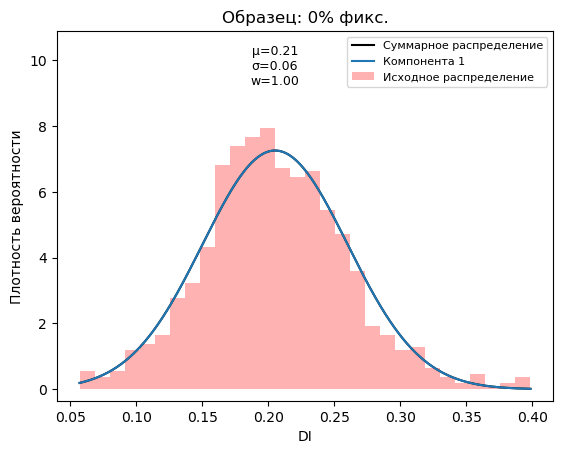

    Среднее  Стандартное отклонение  Доля
0  0.205135                0.055004   1.0
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\1213540585.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


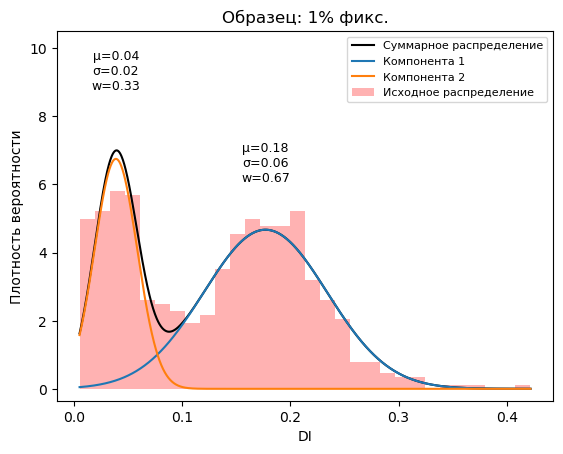

    Среднее  Стандартное отклонение      Доля
0  0.177005                0.056974  0.666951
1  0.038810                0.019684  0.333049
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\1213540585.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


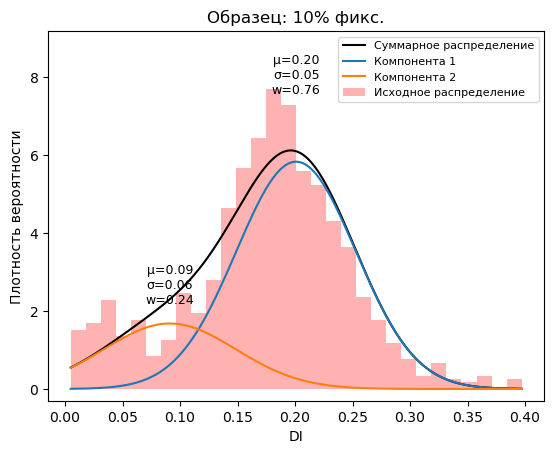

    Среднее  Стандартное отклонение      Доля
0  0.200906                0.051911  0.758528
1  0.091106                0.057361  0.241472
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\1213540585.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


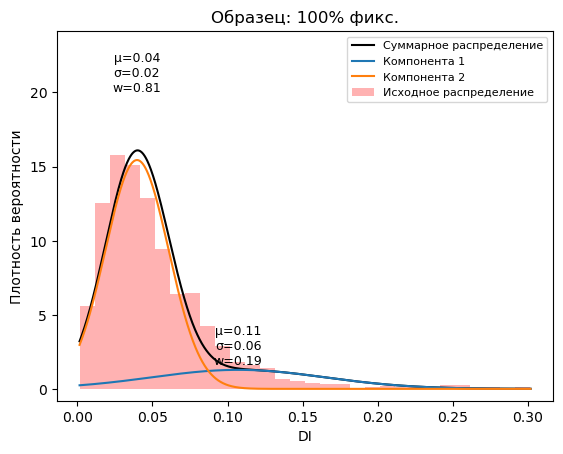

    Среднее  Стандартное отклонение      Доля
0  0.107087                0.057730  0.185642
1  0.039796                0.021041  0.814358
Оптимальное количество компонент: None
Локоть не найден, используется минимальное BIC: 2


C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\1213540585.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)


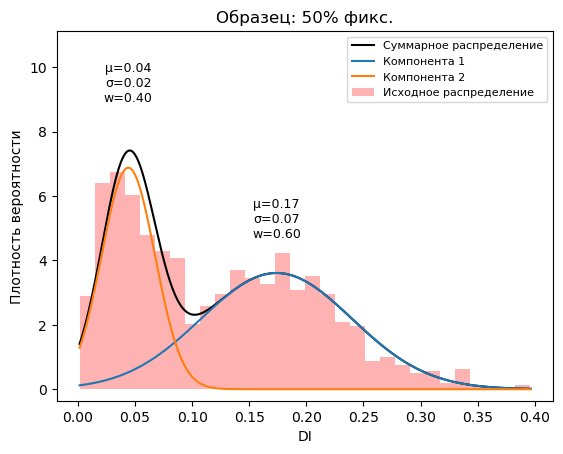

    Среднее  Стандартное отклонение      Доля
0  0.173841                0.066081  0.597974
1  0.044030                0.023311  0.402026
  measurement  peak number   Среднее  Стандартное отклонение      Доля
0          0%            1  0.205135                0.055004  1.000000
1          1%            1  0.177005                0.056974  0.666951
2          1%            2  0.038810                0.019684  0.333049
3         10%            1  0.200906                0.051911  0.758528
4         10%            2  0.091106                0.057361  0.241472
5        100%            1  0.107087                0.057730  0.185642
6        100%            2  0.039796                0.021041  0.814358
7         50%            1  0.173841                0.066081  0.597974
8         50%            2  0.044030                0.023311  0.402026


In [21]:
analyse_peaks(
    data_traces,
    max_components=2,
    penalty_coef=0.1,
    save_name="2025-03-12 peak weights old"
)

C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\3333940954.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)
C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\3333940954.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std, weight = float(mean), float(std), float(weight)
C:\Users\gorod\AppData\Local\Temp\ipykernel_7616\3333940954.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean, std

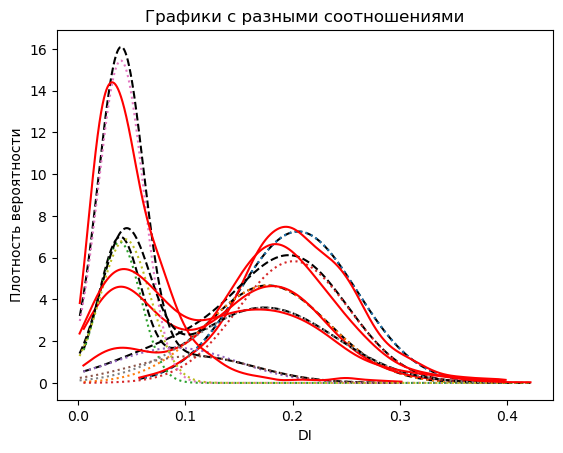

In [28]:
analyse_peaks_one_graph(
    data_traces,
    title='Графики с разными соотношениями'
)
plt.show()

## Новая идея (или обновленная старая)

In [109]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, argrelextrema
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

def find_peaks_and_fit(x, distribution, weight_threshold=0.001):
    peaks, _ = find_peaks(distribution)
    minima_indices = argrelextrema(distribution, np.less)[0]
    
    peak_data = []
    
    for peak in peaks:
        left_min = minima_indices[minima_indices < peak][-1] if minima_indices[minima_indices < peak].size > 0 else 0
        right_min = minima_indices[minima_indices > peak][0] if minima_indices[minima_indices > peak].size > 0 else len(distribution) - 1
        
        x_fit = x[left_min:right_min + 1]
        y_fit = distribution[left_min:right_min + 1]
        
        initial_guess = [distribution[peak], x[peak], (x[right_min] - x[left_min]) / 4]
        params, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)
        
        amplitude, mean, stddev = params
        weight = np.sum(gaussian(x_fit, amplitude, mean, stddev)) / np.sum(distribution)

        if weight > weight_threshold:
            peak_data.append({
                'mean': mean,
                'stddev': stddev,
                'amplitude': amplitude,
                'weight': weight,
            })
    
    return pd.DataFrame(peak_data)

def plot_distribution_with_peaks(x, distribution, peak_df, title=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, distribution, label='Original Distribution', color='black')
    
    total_fit = np.zeros_like(distribution)

    plt.ylim(top=max(distribution) * 1.3)
    height_add = max(distribution)*0.05
    
    for i, row in peak_df.iterrows():
        gauss = gaussian(x, row['amplitude'], row['mean'], row['stddev'])
        total_fit += gauss
        plt.plot(x, gauss, '--', label=f'Peak {i+1}')
        
        label_text = f'Peak {i+1}\nμ={row["mean"]:.2f}\nσ={row["stddev"]:.2f}\nw={row["weight"]:.2f}'
        plt.text(row['mean'], gaussian(row['mean'], row['amplitude'] + height_add, row['mean'], row['stddev']), 
                 label_text, fontsize=9, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8))
    
    # Нормализация суммарного распределения
    integral_original = np.trapz(distribution, x)
    integral_fit = np.trapz(total_fit, x)
    total_fit_normalized = total_fit * (integral_original / integral_fit)
    
    plt.plot(x, total_fit_normalized, label='Total Fit (Normalized)', color='red')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Плотность вероятности')
    if title==None:
        plt.title('Распределение с Гауссовыми пиками')
    else:
        plt.title(f'Распределение для образца: {title}')
    plt.show()

def analyse_peaks(data_traces, save_name=None):
    peaks_weights = pd.DataFrame()

    for measurement in data_traces.keys():
        x, y = kde_plot(data_traces[measurement]["DI"])
        peaks_weight_temp = find_peaks_and_fit(x, y, weight_threshold=0.01)
        plot_distribution_with_peaks(x, y, peaks_weight_temp, title=measurement)
        peaks_weight_temp.insert(0, "peak_number", np.arange(1, 1 + len(peaks_weight_temp)))
        peaks_weight_temp.insert(0, "measurement", [measurement] * len(peaks_weight_temp))
        peaks_weights = pd.concat([peaks_weights, peaks_weight_temp], ignore_index=True)

    if not save_name==None:
        peaks_weights.to_excel(f'{save_name}.xlsx', index=False)
    print(peaks_weights)

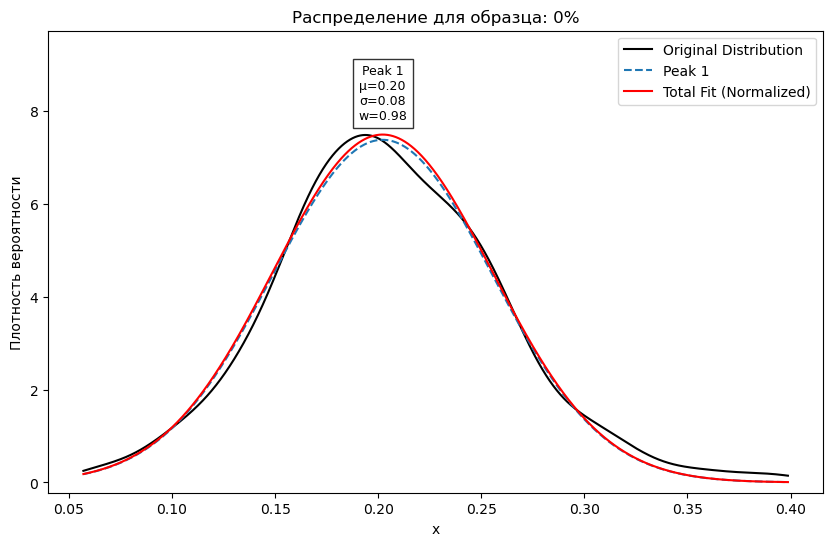

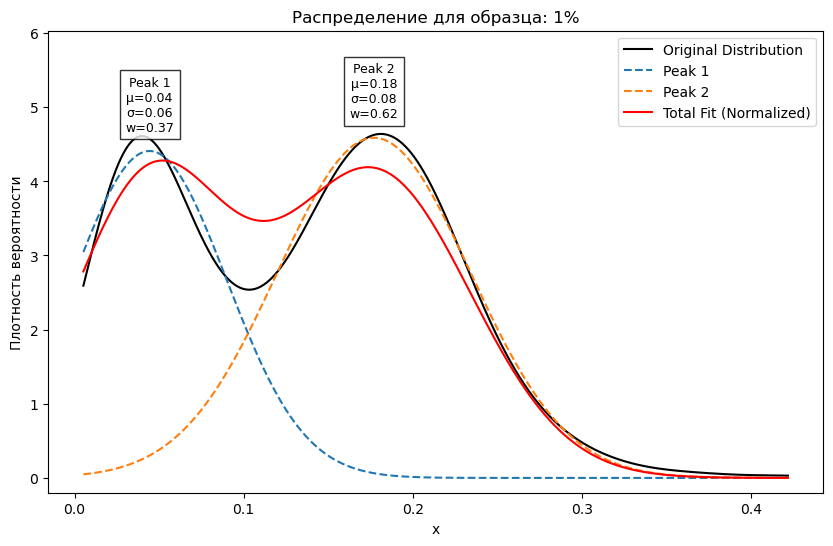

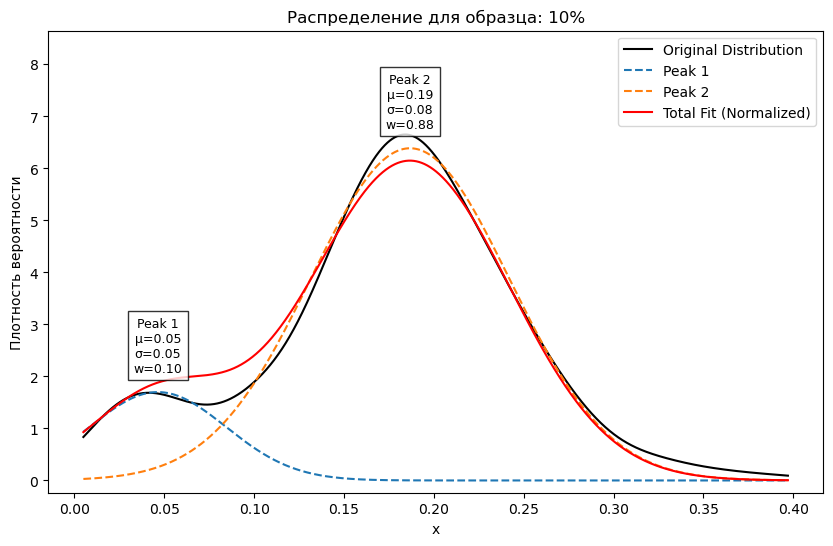

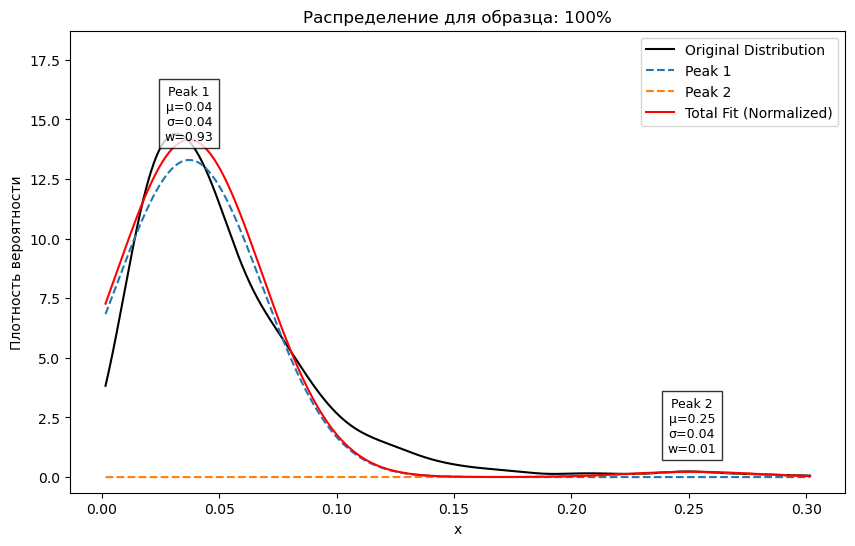

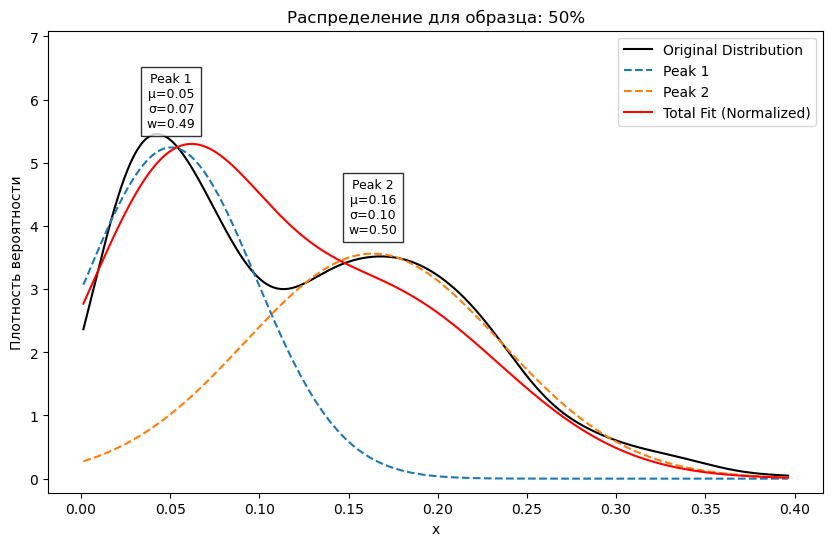

  measurement  peak_number      mean    stddev  amplitude    weight
0          0%            1  0.202136  0.075234   7.373392  0.984915
1          1%            1  0.044402  0.064423   4.407676  0.373780
2          1%            2  0.177051  0.080446   4.586022  0.619917
3         10%            1  0.046350  0.053655   1.698443  0.102459
4         10%            2  0.186704  0.078256   6.384883  0.879848
5        100%            1  0.037194  0.043656  13.297643  0.925718
6        100%            2  0.251236  0.038467   0.210239  0.011793
7         50%            1  0.050532  0.067200   5.242576  0.490906
8         50%            2  0.163659  0.101451   3.561943  0.503380


In [111]:
analyse_peaks(
    data_traces,
    save_name='2025-03-12 peak weights old (new approach)'
)

## Улучшение (автоподбор параметров)

In [6]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, argrelextrema
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

def multi_gaussian(x, *params):
    """Функция для суммы нескольких гауссовых распределений"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amplitude, mean, stddev = params[i:i+3]
        y += gaussian(x, amplitude, mean, stddev)
    return y

def find_peaks_and_fit(x, distribution, weight_threshold=0.001):
    peaks, _ = find_peaks(distribution)
    minima_indices = argrelextrema(distribution, np.less)[0]
    
    peak_data = []
    
    # Первый проход: найти начальные параметры каждого пика
    for peak in peaks:
        left_min = minima_indices[minima_indices < peak][-1] if minima_indices[minima_indices < peak].size > 0 else 0
        right_min = minima_indices[minima_indices > peak][0] if minima_indices[minima_indices > peak].size > 0 else len(distribution) - 1
        
        x_fit = x[left_min:right_min + 1]
        y_fit = distribution[left_min:right_min + 1]
        
        initial_guess = [distribution[peak], x[peak], (x[right_min] - x[left_min]) / 4]
        params, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess, maxfev=10000)
        
        amplitude, mean, stddev = params
        weight = np.sum(gaussian(x_fit, amplitude, mean, stddev)) / np.sum(distribution)

        if weight > weight_threshold:
            peak_data.append({
                'mean': mean,
                'stddev': stddev,
                'amplitude': amplitude,
                'weight': weight,
            })
    
    # Если найдены пики, проведем глобальную оптимизацию
    if peak_data:
        # Подготовим начальные параметры для глобальной оптимизации
        initial_params = []
        for peak in peak_data:
            initial_params.extend([peak['amplitude'], peak['mean'], peak['stddev']])
        
        # Определим границы для параметров
        bounds = []
        for i, peak in enumerate(peak_data):
            # Амплитуда: от 0 до 2*исходной
            bounds.append((0, 2 * peak['amplitude']))
            # Среднее: ±10% от исходного значения
            mean_range = 0.1 * abs(peak['mean'])
            bounds.append((peak['mean'] - mean_range, peak['mean'] + mean_range))
            # Стандартное отклонение: от 0.5*исходного до 2*исходного
            bounds.append((0.5 * peak['stddev'], 2 * peak['stddev']))
        
        # Функция ошибки для минимизации
        def error_function(params):
            y_pred = multi_gaussian(x, *params)
            return np.sum((distribution - y_pred) ** 2)
        
        # Глобальная оптимизация
        result = minimize(error_function, initial_params, bounds=bounds, method='L-BFGS-B')
        optimized_params = result.x
        
        # Обновим peak_data с оптимизированными параметрами
        for i in range(len(peak_data)):
            peak_data[i]['amplitude'] = optimized_params[i*3]
            peak_data[i]['mean'] = optimized_params[i*3+1]
            peak_data[i]['stddev'] = optimized_params[i*3+2]
            
            # Пересчитаем веса с новыми параметрами
            gauss = gaussian(x, peak_data[i]['amplitude'], peak_data[i]['mean'], peak_data[i]['stddev'])
            peak_data[i]['weight'] = np.sum(gauss) / np.sum(distribution)
    
    return pd.DataFrame(peak_data)

def plot_distribution_with_peaks(x, distribution, peak_df, title=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, distribution, label='Original Distribution', color='black')
    
    total_fit = np.zeros_like(distribution)

    plt.ylim(top=max(distribution) * 1.3)
    height_add = max(distribution)*0.05
    
    for i, row in peak_df.iterrows():
        gauss = gaussian(x, row['amplitude'], row['mean'], row['stddev'])
        total_fit += gauss
        plt.plot(x, gauss, '--', label=f'Peak {i+1}')
        
        label_text = f'Peak {i+1}\nμ={row["mean"]:.2f}\nσ={row["stddev"]:.2f}\nw={row["weight"]:.2f}'
        plt.text(row['mean'], gaussian(row['mean'], row['amplitude'] + height_add, row['mean'], row['stddev']), 
                 label_text, fontsize=9, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8))
    
    # Вычисляем ошибку аппроксимации
    mse = np.mean((distribution - total_fit) ** 2)
    
    plt.plot(x, total_fit, label=f'Total Fit (MSE: {mse:.6f})', color='red')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Плотность вероятности')
    if title==None:
        plt.title('Распределение с Гауссовыми пиками')
    else:
        plt.title(f'Распределение для образца: {title}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Возвращаем ошибку для возможного анализа
    return mse

def analyse_peaks(data_traces, save_name=None):
    peaks_weights = pd.DataFrame()
    mse_values = {}

    for measurement in data_traces.keys():
        x, y = kde_plot(data_traces[measurement]["DI"])
        peaks_weight_temp = find_peaks_and_fit(x, y, weight_threshold=0.01)
        mse = plot_distribution_with_peaks(x, y, peaks_weight_temp, title=measurement)
        mse_values[measurement] = mse
        
        peaks_weight_temp.insert(0, "peak_number", np.arange(1, 1 + len(peaks_weight_temp)))
        peaks_weight_temp.insert(0, "measurement", [measurement] * len(peaks_weight_temp))
        peaks_weights = pd.concat([peaks_weights, peaks_weight_temp], ignore_index=True)

    if not save_name==None:
        peaks_weights.to_excel(f'{save_name}.xlsx', index=False)
    
    print("Средняя квадратичная ошибка для каждого измерения:")
    for measurement, mse in mse_values.items():
        print(f"{measurement}: {mse:.6f}")
    
    print("\nРезультаты анализа пиков:")
    print(peaks_weights)

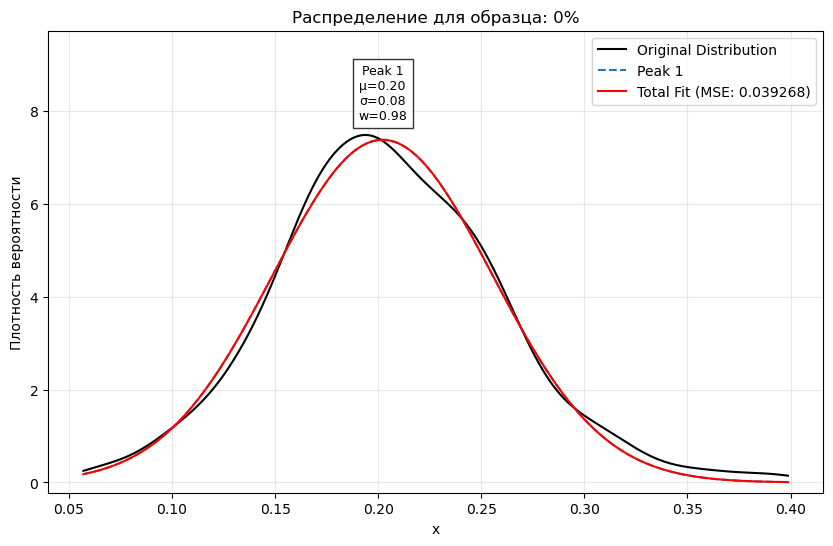

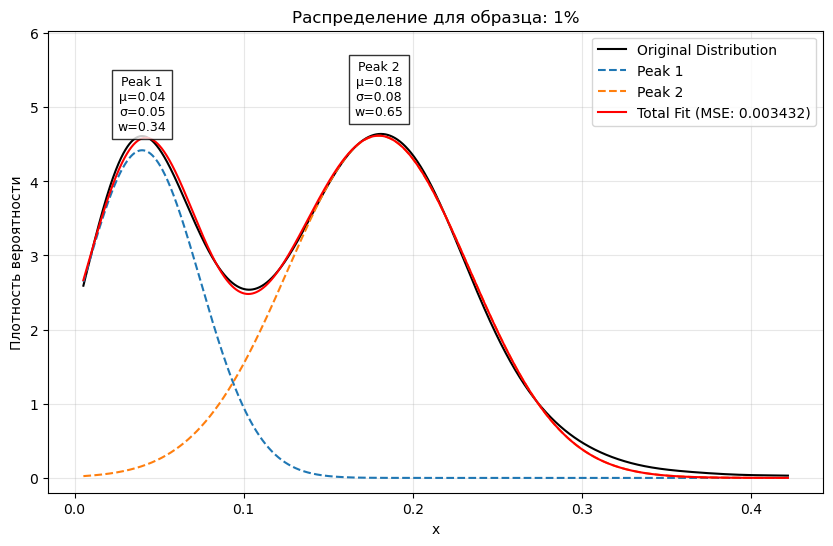

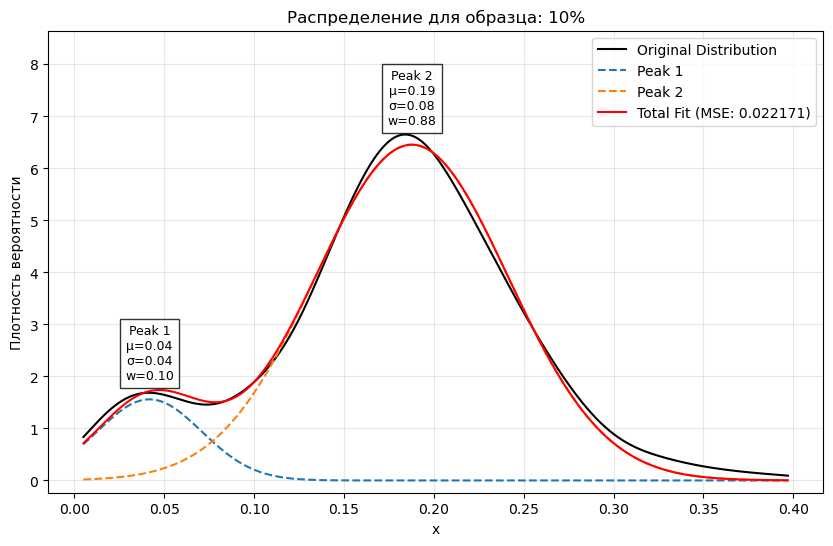

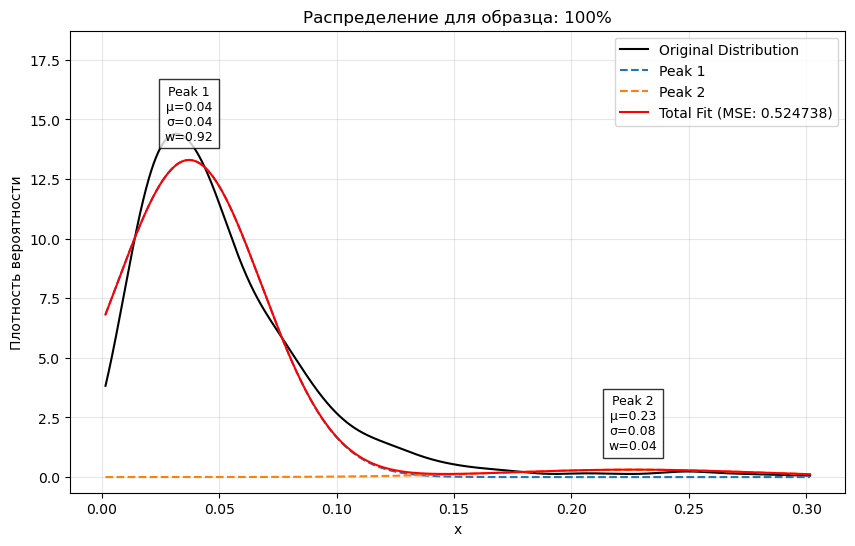

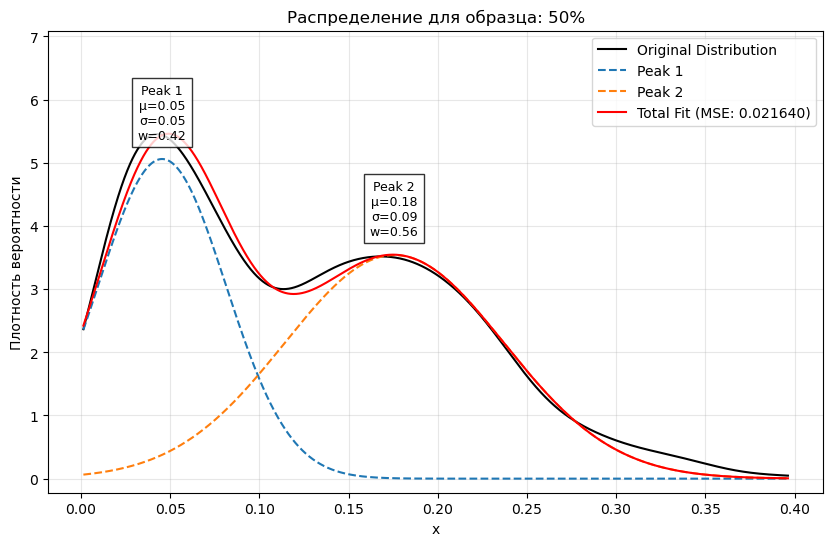

Средняя квадратичная ошибка для каждого измерения:
0%: 0.039268
1%: 0.003432
10%: 0.022171
100%: 0.524738
50%: 0.021640

Результаты анализа пиков:
  measurement  peak_number      mean    stddev  amplitude    weight
0          0%            1  0.202136  0.075234   7.373392  0.984915
1          1%            1  0.039962  0.048429   4.417886  0.336466
2          1%            2  0.179940  0.076287   4.613450  0.654732
3         10%            1  0.041715  0.040953   1.559050  0.103072
4         10%            2  0.187723  0.075755   6.453242  0.878474
5        100%            1  0.037179  0.043557  13.297617  0.924084
6        100%            2  0.226112  0.076934   0.312179  0.040115
7         50%            1  0.045479  0.050501   5.059620  0.419238
8         50%            2  0.175647  0.086972   3.538532  0.564825


In [7]:
analyse_peaks(
    data_traces
)

## Пробую еще раз EM-алгоритм с начальными данными

In [16]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, argrelextrema
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

def multi_gaussian(x, *params):
    """Функция для суммы нескольких гауссовых распределений"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amplitude, mean, stddev = params[i:i+3]
        y += gaussian(x, amplitude, mean, stddev)
    return y

def find_peaks_and_fit(x, distribution, weight_threshold=0.001):
    peaks, _ = find_peaks(distribution)
    minima_indices = argrelextrema(distribution, np.less)[0]
    
    peak_data = []
    
    # Первый проход: найти начальные параметры каждого пика
    for peak in peaks:
        left_min = minima_indices[minima_indices < peak][-1] if minima_indices[minima_indices < peak].size > 0 else 0
        right_min = minima_indices[minima_indices > peak][0] if minima_indices[minima_indices > peak].size > 0 else len(distribution) - 1
        
        x_fit = x[left_min:right_min + 1]
        y_fit = distribution[left_min:right_min + 1]
        
        initial_guess = [distribution[peak], x[peak], (x[right_min] - x[left_min]) / 4]
        params, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess, maxfev=10000)
        
        amplitude, mean, stddev = params
        weight = np.sum(gaussian(x_fit, amplitude, mean, stddev)) / np.sum(distribution)

        if weight > weight_threshold:
            peak_data.append({
                'mean': mean,
                'stddev': stddev,
                'amplitude': amplitude,
                'weight': weight,
            })
    
    # Если найдены пики, проведем оптимизацию с помощью EM-алгоритма (GaussianMixture)
    if peak_data:
        from sklearn.mixture import GaussianMixture
        
        n_components = len(peak_data)
        
        # Подготовим начальные параметры для EM-алгоритма с правильной размерностью
        means_init = np.array([[peak['mean']] for peak in peak_data])  # (n_components, 1)
        precisions_init = np.array([[1/(peak['stddev']**2)] for peak in peak_data])  # (n_components, 1)
        weights_init = np.array([peak['weight'] for peak in peak_data])
        weights_init = weights_init / weights_init.sum()  # Нормализуем веса
        
        # Создаем модель с заданными начальными параметрами
        gm = GaussianMixture(
            n_components=n_components,
            means_init=means_init,
            weights_init=weights_init,
            max_iter=10000,
            covariance_type='diag',
            init_params='kmeans'  # Изменено с 'random' на 'kmeans'
        )
        
        # Не используем precisions_init напрямую, так как может быть проблема в старых версиях
        
        # Создаем веса для каждой точки
        norm_weights = distribution / distribution.sum()
        
        # Создаем взвешенную выборку путем повторения точек в соответствии с их весами
        n_samples = 100000  # Количество семплов в новой выборке
        indices = np.random.choice(len(x), size=n_samples, p=norm_weights)
        x_weighted = x[indices].reshape(-1, 1)
        
        # Обучаем модель на взвешенных данных
        gm.fit(x_weighted)
        
        # Обновляем peak_data с параметрами, полученными из EM-алгоритма
        for i in range(len(peak_data)):
            # Получаем параметры из обученной модели
            mean = gm.means_[i][0]
            
            # Получаем ковариацию и преобразуем в stddev
            if hasattr(gm, 'covariances_'):
                stddev = np.sqrt(gm.covariances_[i][0])
            else:
                stddev = 1.0 / np.sqrt(gm.precisions_[i][0])
                
            weight = gm.weights_[i]
            
            # Вычисляем амплитуду, соответствующую gaussian функции
            amplitude = weight * (1 / (stddev * np.sqrt(2 * np.pi)))
            
            # Обновляем параметры пика
            peak_data[i]['mean'] = mean
            peak_data[i]['stddev'] = stddev
            peak_data[i]['amplitude'] = amplitude
            
            # Пересчитываем веса с новыми параметрами для визуализации
            gauss = gaussian(x, peak_data[i]['amplitude'], peak_data[i]['mean'], peak_data[i]['stddev'])
            peak_data[i]['weight'] = np.sum(gauss) / np.sum(distribution)
    
    return pd.DataFrame(peak_data)

def plot_distribution_with_peaks(x, distribution, peak_df, title=None):
    plt.figure(figsize=(10, 6))
    plt.hist(distribution, bins=50, density=True, alpha=0.6, color='darkgreen')
    plt.plot(x, distribution, label='Original Distribution', color='black')
    
    total_fit = np.zeros_like(distribution)

    plt.ylim(top=max(distribution) * 1.3)
    height_add = max(distribution)*0.05
    
    for i, row in peak_df.iterrows():
        gauss = gaussian(x, row['amplitude'], row['mean'], row['stddev'])
        total_fit += gauss
        plt.plot(x, gauss, '--', label=f'Peak {i+1}')
        
        label_text = f'Peak {i+1}\nμ={row["mean"]:.2f}\nσ={row["stddev"]:.2f}\nw={row["weight"]:.2f}'
        plt.text(row['mean'], gaussian(row['mean'], row['amplitude'] + height_add, row['mean'], row['stddev']), 
                 label_text, fontsize=9, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8))
    
    # Вычисляем ошибку аппроксимации
    mse = np.mean((distribution - total_fit) ** 2)
    
    plt.plot(x, total_fit, label=f'Total Fit (MSE: {mse:.6f})', color='red')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Плотность вероятности')
    if title==None:
        plt.title('Распределение с Гауссовыми пиками')
    else:
        plt.title(f'Распределение для образца: {title}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Возвращаем ошибку для возможного анализа
    return mse

def analyse_peaks(data_traces, save_name=None):
    peaks_weights = pd.DataFrame()
    mse_values = {}

    for measurement in data_traces.keys():
        x, y = kde_plot(data_traces[measurement]["DI"])
        peaks_weight_temp = find_peaks_and_fit(x, y, weight_threshold=0.01)
        mse = plot_distribution_with_peaks(x, y, peaks_weight_temp, title=measurement)
        mse_values[measurement] = mse
        
        peaks_weight_temp.insert(0, "peak_number", np.arange(1, 1 + len(peaks_weight_temp)))
        peaks_weight_temp.insert(0, "measurement", [measurement] * len(peaks_weight_temp))
        peaks_weights = pd.concat([peaks_weights, peaks_weight_temp], ignore_index=True)

    if not save_name==None:
        peaks_weights.to_excel(f'{save_name}.xlsx', index=False)
    
    print("Средняя квадратичная ошибка для каждого измерения:")
    for measurement, mse in mse_values.items():
        print(f"{measurement}: {mse:.6f}")
    
    print("\nРезультаты анализа пиков:")
    print(peaks_weights)

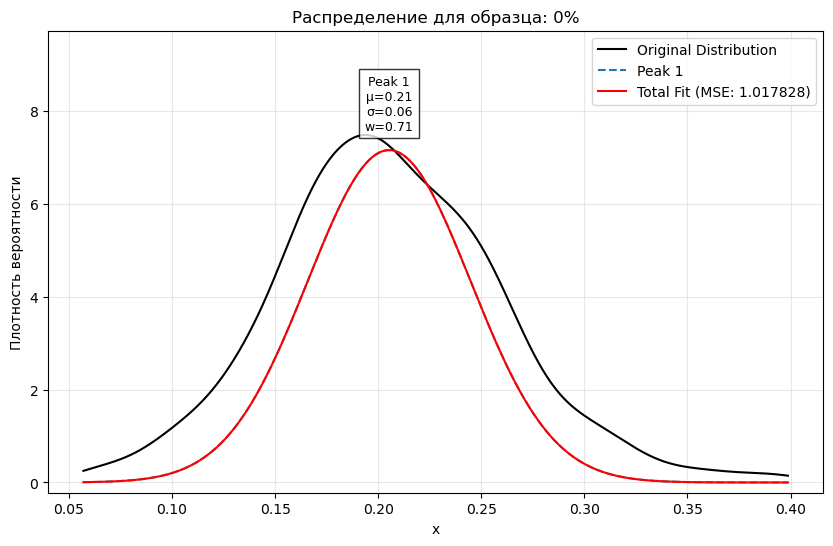

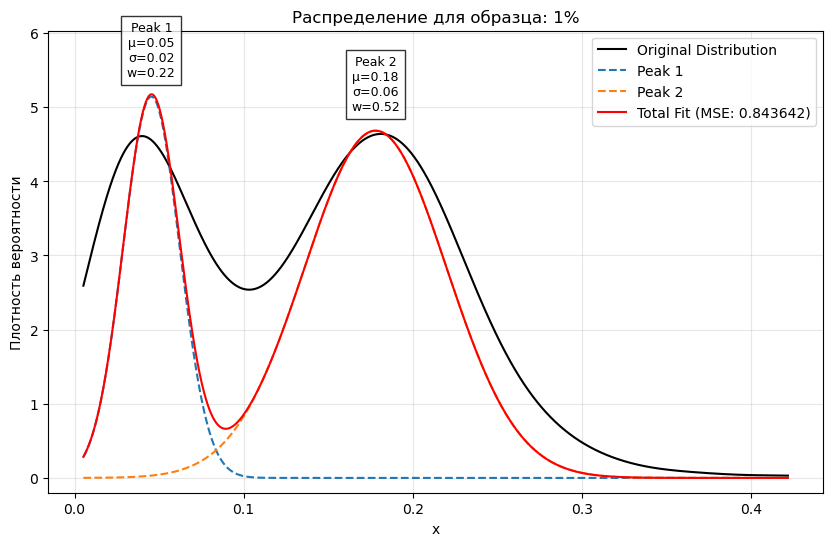

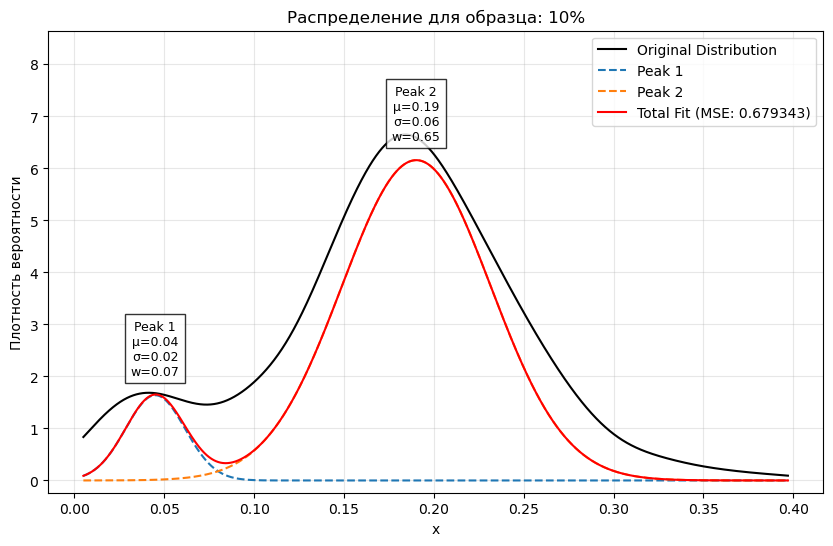

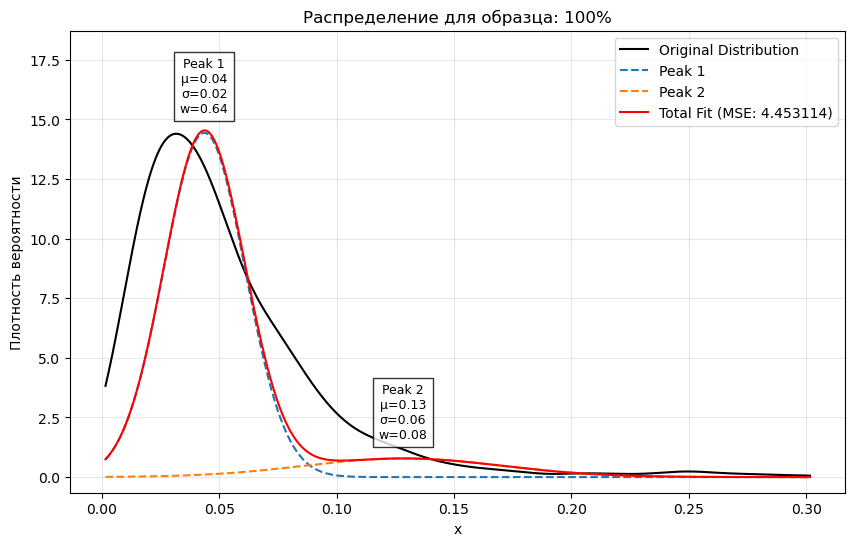

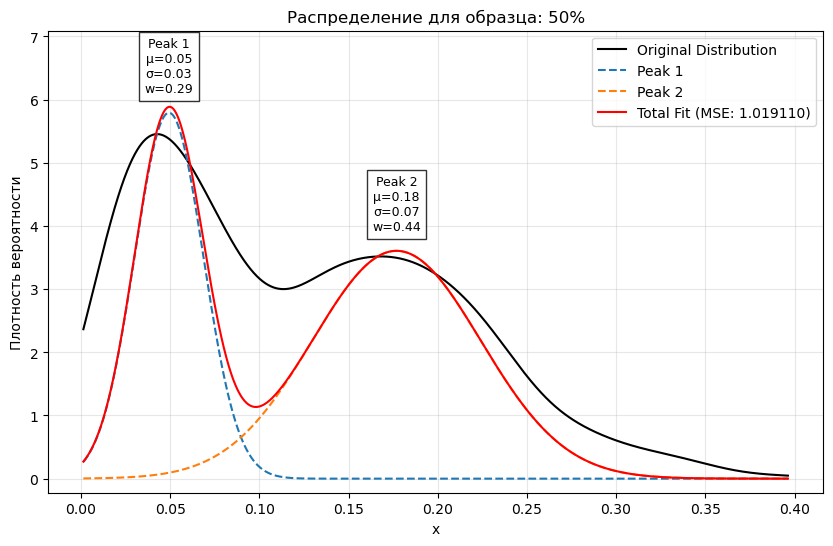

Средняя квадратичная ошибка для каждого измерения:
0%: 1.017828
1%: 0.843642
10%: 0.679343
100%: 4.453114
50%: 1.019110

Результаты анализа пиков:
  measurement  peak_number      mean    stddev  amplitude    weight
0          0%            1  0.205299  0.055784   7.151546  0.710591
1          1%            1  0.045453  0.023617   5.140889  0.224199
2          1%            2  0.178014  0.059277   4.681917  0.516596
3         10%            1  0.044967  0.023436   1.638546  0.068491
4         10%            2  0.190193  0.058565   6.156286  0.648113
5        100%            1  0.043667  0.024409  14.433506  0.636768
6        100%            2  0.128278  0.059640   0.781904  0.084794
7         50%            1  0.049340  0.027335   5.791614  0.289382
8         50%            2  0.176903  0.066727   3.606106  0.442669


In [17]:
analyse_peaks(
    data_traces
)

## Теперь оптимизирую EM-алгоритм

In [171]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, argrelextrema
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

def multi_gaussian(x, *params):
    """Функция для суммы нескольких гауссовых распределений"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amplitude, mean, stddev = params[i:i+3]
        y += gaussian(x, amplitude, mean, stddev)
    return y

def find_peaks_and_fit(data_original, EM=True, optimise=True, n_components=None, n_as_max=False, min_components=1, max_components=10, 
                  weight_threshold=0.01, penalty_factor=0.01, random_state=42):
    """
    Анализирует распределение на наличие пиков с помощью EM-алгоритма.
    
    Параметры:
    ----------
    data : array-like
        Одномерный массив данных для анализа.
    n_components : int, optional
        Количество компонент для модели. Если None, будет подобрано автоматически.
    min_components : int, default=1
        Минимальное количество компонент для автоматического подбора.
    max_components : int, default=10
        Максимальное количество компонент для автоматического подбора.
    weight_threshold : float, default=0.01
        Порог веса компоненты для её учёта.
    penalty_factor : float, default=0.01
        Фактор штрафа за большое количество компонент.
    random_state : int, default=42
        Случайное зерно для воспроизводимости результатов.
    
    Возвращает:
    -----------
    DataFrame
        Датафрейм с информацией о пиках: среднее, стандартное отклонение,
        амплитуда и вес.
    """
    if (n_components is not None) and n_as_max:
        print('Error')
        return
    
    x, distribution_kde = kde_plot(data_original)

    if n_as_max or not EM:
        peaks, _ = find_peaks(distribution_kde)
        minima_indices = argrelextrema(distribution_kde, np.less)[0]

        peak_data = []
    
        # Находим начальные параметры каждого пика
        for peak in peaks:
            left_min = minima_indices[minima_indices < peak][-1] if minima_indices[minima_indices < peak].size > 0 else 0
            right_min = minima_indices[minima_indices > peak][0] if minima_indices[minima_indices > peak].size > 0 else len(distribution_kde) - 1
            
            x_fit = x[left_min:right_min + 1]
            y_fit = distribution_kde[left_min:right_min + 1]
            
            initial_guess = [distribution_kde[peak], x[peak], (x[right_min] - x[left_min]) / 4]
            params, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess, maxfev=10000)
            
            amplitude, mean, stddev = params
            weight = np.sum(gaussian(x_fit, amplitude, mean, stddev)) / np.sum(distribution_kde)
    
            if weight > weight_threshold:
                peak_data.append({
                    'mean': mean,
                    'stddev': stddev,
                    'weight': weight,
                    'amplitude': amplitude,
                })
        
        n_components = len(peak_data)
        
        peaks_df = pd.DataFrame(peak_data)

    data = np.array(data_original).reshape(-1, 1)
    
    # Если количество компонент не задано, подбираем автоматически
    if EM:
        if n_components is None:
            bic_scores = []
            n_components_range = range(min_components, max_components + 1)
            
            for n in n_components_range:
                gmm = GaussianMixture(n_components=n, tol=1e-5, max_iter=10000, random_state=random_state)
                gmm.fit(data)
                # Добавляем штраф за большое количество компонент
                penalized_bic = gmm.bic(data) + penalty_factor * n * np.log(len(data))
                bic_scores.append(penalized_bic)
            
            # Используем метод локтя для определения оптимального количества компонент
            try:
                knee = KneeLocator(
                    n_components_range, bic_scores, 
                    curve='convex', direction='decreasing'
                )
                optimal_n = knee.elbow
                if optimal_n is None:
                    optimal_n = min_components
            except Exception:
                # Если метод локтя не сработал, берем компоненту с минимальным BIC
                optimal_n = n_components_range[np.argmin(bic_scores)]
            
            n_components = optimal_n
        
        # Обучаем GMM с оптимальным количеством компонент
        gmm = GaussianMixture(n_components=n_components, tol=1e-5, max_iter=10000, random_state=random_state)
        gmm.fit(data)
        
        # Извлекаем параметры компонент
        weights = gmm.weights_
        means = gmm.means_.flatten()
        stddevs = np.sqrt(gmm.covariances_.flatten())
        
        # Создаем датафрейм с параметрами компонент
        peaks_df = pd.DataFrame({
            'mean': means,
            'stddev': stddevs,
            'weight': weights,
            'amplitude': weights / (stddevs * np.sqrt(2 * np.pi))
        })
    
        # Сортируем по средним значениям
        peaks_df = peaks_df.sort_values('mean').reset_index(drop=True)
    
        # Фильтруем компоненты по порогу веса
        significant_peaks = peaks_df[peaks_df['weight'] >= weight_threshold].copy()
    
        if len(significant_peaks) == 0:
            # Если нет значимых пиков, возвращаем самый большой
            significant_peaks = peaks_df.sort_values('weight', ascending=False).head(1).copy()
            
        peaks_df = significant_peaks

    if optimise:
        # Подготовим начальные параметры для глобальной оптимизации
        initial_params = []
        for i, peak in peaks_df.iterrows():
            initial_params.extend([peak['amplitude'], peak['mean'], peak['stddev']])
        
        # Определим границы для параметров
        bounds = []
        for i, peak in peaks_df.iterrows():
            # Амплитуда: от 0 до 2*исходной
            bounds.append((0, 2 * peak['amplitude']))
            # Среднее: ±10% от исходного значения
            mean_range = 0.10 * abs(peak['mean'])
            bounds.append((peak['mean'] - mean_range, peak['mean'] + mean_range))
            # Стандартное отклонение: от 0.5*исходного до 2*исходного
            bounds.append((0.5 * peak['stddev'], 2 * peak['stddev']))
        
        # Функция ошибки для минимизации
        def error_function(params):
            y_pred = multi_gaussian(x, *params)
            return np.sum((distribution_kde - y_pred) ** 2)
        
        # Глобальная оптимизация
        result = minimize(error_function, initial_params, bounds=bounds, method='L-BFGS-B')
        optimized_params = result.x
        
        # Обновим peaks_df с оптимизированными параметрами
        for i in range(len(peaks_df)):
            peaks_df.iloc[i]['amplitude'] = optimized_params[i*3]
            peaks_df.iloc[i]['mean'] = optimized_params[i*3+1]
            peaks_df.iloc[i]['stddev'] = optimized_params[i*3+2]
            
            # Пересчитаем веса с новыми параметрами
            gauss = gaussian(x, peaks_df.iloc[i]['amplitude'], peaks_df.iloc[i]['mean'], peaks_df.iloc[i]['stddev'])
            peaks_df.iloc[i]['weight'] = np.sum(gauss) / np.sum(distribution_kde)
    
    total_weight = sum([row['weight'] for i, row in peaks_df.iterrows()])
    
    # Нормализуем веса, чтобы их сумма была равна 1
    for i in range(len(peaks_df)):
        peaks_df.iloc[i]['weight'] /= total_weight
    
    return peaks_df

def plot_distribution_with_peaks(trace, peak_df, parameter, title=None):
    plt.figure(figsize=(10, 6))

    # Гистограмма исходного распределения
    # plt.hist(trace, bins=60, density=True, alpha=0.6, color='g')
    std_dev = np.std(trace)
    bandwidth = 1.06 * std_dev * len(trace) ** (-1/5)
    sns.histplot(trace, stat='density', binwidth=bandwidth, alpha=0.5, color='cornflowerblue', element='step')

    # kde для исходного распределения
    x, distribution = kde_plot(trace)
    plt.plot(x, distribution, label='Original Distribution', color='slateblue')
    
    total_fit = np.zeros_like(distribution)

    height_add = max(distribution)*0.05
    
    for i, row in peak_df.iterrows():
        gauss = gaussian(x, row['amplitude'], row['mean'], row['stddev'])
        total_fit += gauss
        plt.plot(x, gauss, '--', label=f'Peak {i+1}')
        
        label_text = f'Peak {i+1}\nμ={row["mean"]:.2f}\nσ={row["stddev"]:.2f}\nw={row["weight"]:.2f}'
        plt.text(row['mean'], gaussian(row['mean'], row['amplitude'] + height_add, row['mean'], row['stddev']), 
                 label_text, fontsize=9, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8))

    plt.ylim(top=max(max(distribution), max(total_fit)) * 1.3)
    
    # Вычисляем ошибку аппроксимации
    mse = np.mean((distribution - total_fit) ** 2)
    
    plt.plot(x, total_fit, label=f'Total Fit (MSE: {mse:.6f})', color='red')
    plt.legend()
    plt.xlabel(parameter)
    plt.ylabel('Плотность вероятности')
    if title==None:
        plt.title('Распределение с Гауссовыми пиками')
    else:
        plt.title(f'Распределение для образца: {title}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Возвращаем ошибку для возможного анализа
    return mse

def analyse_peaks(data_traces, parameter, sample_names=None, save_name=None, EM=True, optimise=True, n_as_max=False, n_components=None, weight_threshold=0.005, max_components=10, penalty_factor=0.1):
    peaks_weights = pd.DataFrame()
    mse_values = {}

    if sample_names==None:
        sample_names = data_traces.keys()

    for measurement in sample_names:
        peaks_weight_temp = find_peaks_and_fit(data_traces[measurement][parameter], EM=EM, optimise=optimise, n_as_max=n_as_max, n_components=n_components, weight_threshold=weight_threshold, penalty_factor=penalty_factor, max_components=max_components)
        mse = plot_distribution_with_peaks(data_traces[measurement][parameter], peaks_weight_temp, parameter, title=measurement)
        mse_values[measurement] = mse
        
        peaks_weight_temp.insert(0, "peak_number", np.arange(1, 1 + len(peaks_weight_temp)))
        peaks_weight_temp.insert(0, "measurement", [measurement] * len(peaks_weight_temp))
        peaks_weights = pd.concat([peaks_weights, peaks_weight_temp], ignore_index=True)

    if not save_name==None:
        peaks_weights.to_excel(f'{save_name}.xlsx', index=False)
    
    print("Средняя квадратичная ошибка для каждого измерения:")
    for measurement, mse in mse_values.items():
        print(f"{measurement}: {mse:.6f}")
    
    print("\nРезультаты анализа пиков:")
    print(peaks_weights)

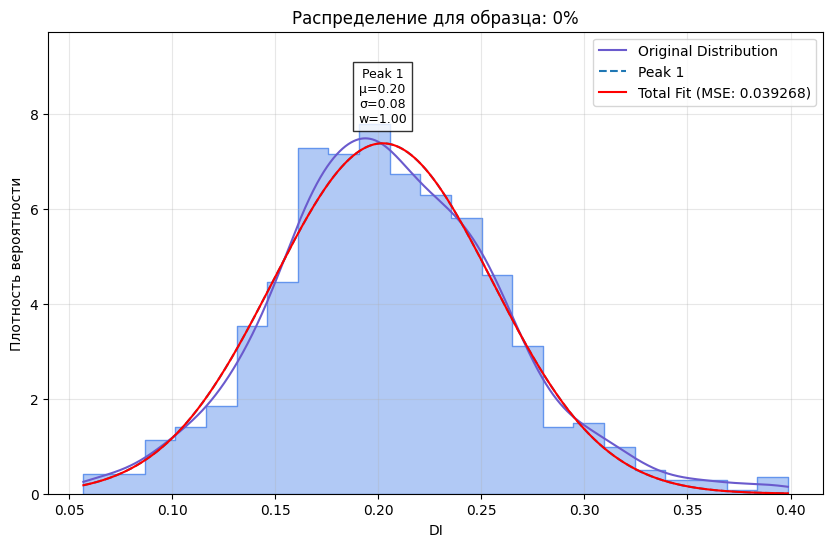

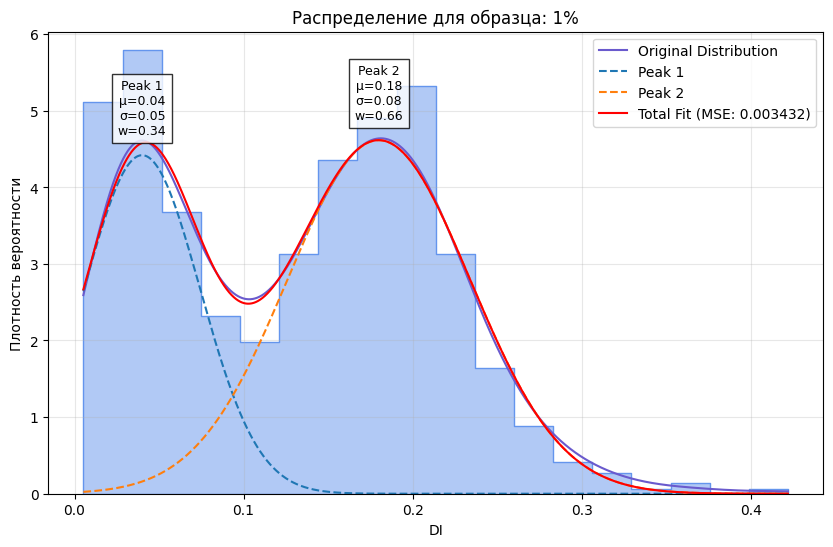

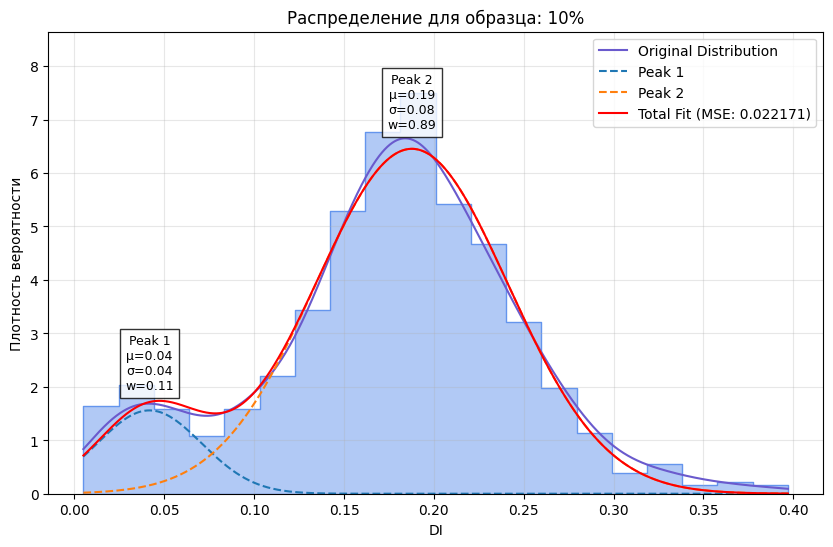

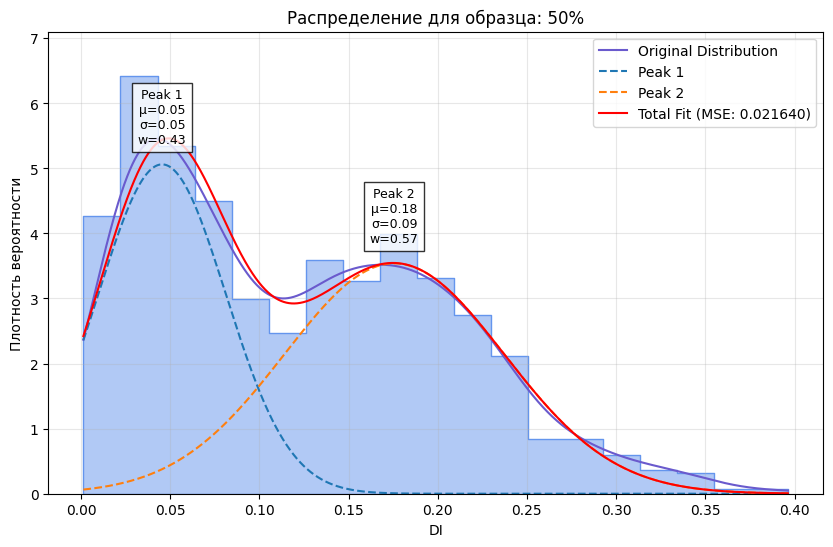

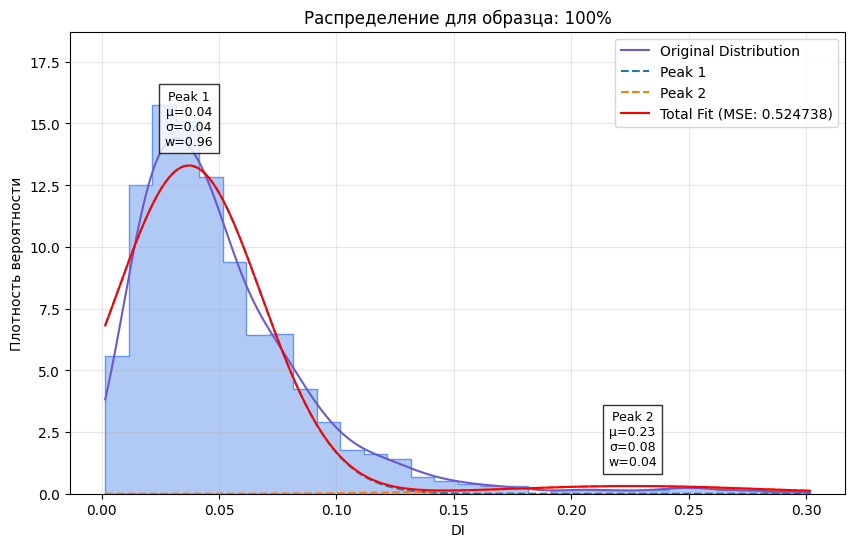

Средняя квадратичная ошибка для каждого измерения:
0%: 0.039268
1%: 0.003432
10%: 0.022171
50%: 0.021640
100%: 0.524738

Результаты анализа пиков:
  measurement  peak_number      mean    stddev    weight  amplitude
0          0%            1  0.202136  0.075234  1.000000   7.373392
1          1%            1  0.039962  0.048429  0.339454   4.417886
2          1%            2  0.179940  0.076287  0.660546   4.613450
3         10%            1  0.041715  0.040953  0.105010   1.559050
4         10%            2  0.187723  0.075755  0.894990   6.453242
5         50%            1  0.045479  0.050501  0.426028   5.059620
6         50%            2  0.175647  0.086972  0.573972   3.538532
7        100%            1  0.037179  0.043557  0.958395  13.297617
8        100%            2  0.226112  0.076934  0.041605   0.312179


In [172]:
analyse_peaks(
    data_traces,
    parameter='DI',
    sample_names = ['0%', '1%', '10%', '50%', '100%'],
    save_name = '2025-03-12 peak weights old',
    n_as_max=True,
    EM=False,
    optimise=True
)